# Proyecto de comparación de distintas arquitecturas de redes neuronales para la resolución del problema rock-paper-scissors
Alumnos:
1. Oriol
2. Mei

# 1. Configuración del Entorno y Herramientas

## 1.1 Importación de librarias y detección de Hardware

Importación de las librerías que se usarán a lo largo del desarrollo de todo el proyecto

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import time
import psutil
import gc
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from typing import Dict, List, Tuple, Any


Se configuran las semillas para reproducibilidad y se prepara el dispositivo. Dado que estamos ejecutando en un MacBook M4 Pro, utilizaremos el backend mps (Metal Performance Shaders) para aceleración por GPU.

In [20]:

# Configuración de Semillas para Reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Detección de Dispositivo (Prioridad MPS para Apple Silicon)
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"✅ Aceleración MPS activada (Apple Silicon).")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU CUDA detectada.")
    else:
        device = torch.device("cpu")
        print("⚠️ GPU no disponible. Usando CPU.")
    return device

DEVICE = get_device()

# Configuración de Rutas (Ajustar según ubicación real)
BASE_PATH = Path(".")
DATA_PATH = BASE_PATH / "Dataset"
TRAIN_PATH = DATA_PATH / "train"
VALID_PATH = DATA_PATH / "valid"
TEST_PATH = DATA_PATH / "test"
CHECKPOINT_PATH = BASE_PATH / "checkpoints"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

print(f"📂 Directorio de datos: {DATA_PATH.resolve()}")

✅ Aceleración MPS activada (Apple Silicon).
📂 Directorio de datos: /Users/oriolpalacios/MyProjects/Dataset


## 1.2 Registro Global de resultados

Para cumplir con el objetivo de la evaluación comparativa integral, inicializamos un diccionario global. Esto almacenará automáticamente las métricas de la "mejor configuración" encontrada para cada una de las 5 arquitecturas requeridas.

In [4]:
# Estructura global para almacenar el mejor resultado de cada arquitectura
ALL_RESULTS = {
    "1_ANN_Custom": None,       # Red Neuronal Artificial convencional
    "2_CNN_Custom": None,       # CNN personalizada
    "3_Transfer_ResNet": None,  # Arquitectura preexistente 1
    "4_SqueezeNet": None,       # Arquitectura preexistente 2
    "5_DenseNet": None          # Arquitectura preexistente 3
}

def register_result(model_name: str, metrics: dict):
    """Guarda los resultados finales de una arquitectura en el registro global."""
    print(f"📝 Registrando resultados para: {model_name}")
    ALL_RESULTS[model_name] = metrics
    
    # Visualización rápida del estado actual
    df = pd.DataFrame(ALL_RESULTS).T
    display(df) # type: ignore (display funciona en Jupyter)

## 1.3 Gestión de memoria

Dado que el M4 Pro usa memoria unificada, la RAM y la VRAM se comparten. Esta función es crítica para evitar fugas de memoria entre experimentos y asegurar que gc y el caché de mps se limpien correctamente.

In [14]:
def get_memory_usage():
    """Retorna el uso de memoria del proceso actual en GB."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1e9

def clear_memory(keep_vars=['ALL_RESULTS', 'train_val_loop', 'evaluate_with_tta', 'HandGestureDataset', 'ReplaceWhiteBackground']):
    """
    Limpia agresivamente la memoria RAM y VRAM (MPS/CUDA).
    Elimina variables globales que no estén en la lista de seguridad.
    """
    vars_to_delete = ['model', 'optimizer', 'criterion', 'train_loader', 'valid_loader', 'test_loader', 'history', 'train_dl', 'valid_dl']

    # 1. Eliminar variables globales no esenciales
    for var in list(globals().keys()):
        # Saltar variables privadas, las que queremos mantener, y las built-in
        if var.startswith('_') or var in keep_vars:
            continue
            
        # Eliminar variables específicas del modelo
        if var in vars_to_delete:
            try:
                del globals()[var]
                print(f"   Deleted: {var}")
            except:
                pass
    
    # 2. Garbage Collection de Python
    gc.collect()
    
    # 3. Vaciar caché de PyTorch
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print(f" Memoria liberada. Uso actual: {get_memory_usage():.2f} GB")

## 1.4 Utilidades de Preprocesamiento (Dataset & Transforms)

In [58]:
class ReplaceWhiteBackground:
    """Reemplaza fondos blancos puros con ruido o color para evitar sesgo."""
    def __init__(self, threshold=0.9, p=0.5, noise_type='gaussian'):
        self.threshold = threshold
        self.p = p
        self.noise_type = noise_type

    def __call__(self, img_tensor):
        if random.random() > self.p:
            return img_tensor

        # Detectar blanco (valores altos en los 3 canales)
        mask = (img_tensor[0] > self.threshold) & \
               (img_tensor[1] > self.threshold) & \
               (img_tensor[2] > self.threshold)

        if self.noise_type == 'gaussian':
            background = torch.randn_like(img_tensor) * 0.5 + 0.5
        elif self.noise_type == 'color':
            background = torch.rand(3, 1, 1).expand_as(img_tensor)
        else:
            return img_tensor

        result = img_tensor.clone()
        mask_expanded = mask.unsqueeze(0).expand_as(img_tensor)
        # Aplicar fondo solo donde la máscara es True
        try:
            result[mask_expanded] = background[mask_expanded]
        except RuntimeError:
            pass # Fallback seguro
            
        return result

def get_dataloaders(train_dir, valid_dir, test_dir, train_transform, valid_transform, batch_size):
    """Factory function para crear DataLoaders limpios."""
    train_ds = ImageFolder(root=train_dir, transform=train_transform)
    valid_ds = ImageFolder(root=valid_dir, transform=valid_transform)
    test_ds = ImageFolder(root=test_dir, transform=valid_transform)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    return train_dl, valid_dl, test_dl, train_ds.classes

## 1.5 Funciones Helper de Entrenamiento y Evaluación

Hemos abstraído el bucle de entrenamiento en una función train_val_loop robusta que maneja el Early Stopping y el registro de tiempos. También incluimos evaluate_with_tta para aplicar Test Time Augmentation.

In [75]:
def count_parameters(model):
    """Cuenta parámetros totales y entrenables."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def train_val_loop(model, train_loader, valid_loader, criterion, optimizer, 
                   epochs=30, patience=5, name="model"):
    """
    Pipeline estándar de entrenamiento y validación con Early Stopping.
    Retorna: history (dict), best_model_state (dict), training_time (sec)
    """
    best_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    start_time = time.time()
    
    print(f"Iniciando entrenamiento: {name} | Epochs: {epochs} | Patience: {patience}")
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        # --- Metrics Calculation ---
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(valid_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] T.Loss: {avg_train_loss:.4f} T.Acc: {train_acc:.4f} | V.Loss: {avg_val_loss:.4f} V.Acc: {val_acc:.4f}")
        
        # --- Early Stopping Check ---
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict() # Guardar en memoria
            patience_counter = 0
            # Opcional: Guardar en disco si es muy pesado
            # torch.save(model.state_dict(), CHECKPOINT_PATH / f"{name}_best.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\tEarly stopping activado en época {epoch+1}")
                break
                
    total_time = time.time() - start_time
    print(f"\t->Tiempo total de entrenamiento: {total_time:.2f}s")
    
    # Cargar el mejor estado antes de retornar
    if best_model_state:
        model.load_state_dict(best_model_state)
        
    return history, best_model_state, total_time

def evaluate_with_tta(model, test_loader, use_tta=False):
    """
    Evalúa el modelo en test set. Soporta Test Time Augmentation simple (flip horizontal).
    Retorna métricas detalladas e inferencia por imagen.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    total_images = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            total_images += images.size(0)
            
            if use_tta:
                # Original + Flip Horizontal
                out1 = model(images)
                out2 = model(torch.flip(images, dims=[3]))
                # Promedio de logits (o softmax)
                outputs = (out1 + out2) / 2
            else:
                outputs = model(images)
                
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    inference_time = (time.time() - start_time) / total_images
    
    # Cálculo de métricas
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_macro': f1,
        'inference_time_ms': inference_time * 1000,
        'predictions': all_preds,
        'targets': all_labels
    }

def show_error_examples(dataset, preds, targets, classes, num_show=10):
    """Visualiza ejemplos donde el modelo falló."""
    errors = [i for i, (p, t) in enumerate(zip(preds, targets)) if p != t]
    
    if not errors:
        print("¡No hay errores! El modelo es perfecto.")
        return

    num_show = min(num_show, len(errors))
    indices = random.sample(errors, num_show)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img, _ = dataset[idx] # Obtener imagen original
        # Desnormalizar para visualización (asumiendo estandarización típica)
        img = img * 0.225 + 0.456 
        img = torch.clamp(img, 0, 1)
        
        plt.subplot(2, 5, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred: {classes[preds[idx]]}\nReal: {classes[targets[idx]]}", color='red', fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import json

def plot_metrics(history: dict, title: str = "Model Performance"):
    """
    Grafica universal de curvas de Loss y Accuracy.
    Recibe un diccionario con keys: 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Gráfico de Accuracy
    ax2.plot(epochs, history['train_acc'], 'g-o', label='Training Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'orange', marker='o', label='Validation Acc', linewidth=2)
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Anotación del mejor valor
    best_val_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_val_acc) + 1
    ax2.annotate(f'Best: {best_val_acc:.2%}', 
                 xy=(best_epoch, best_val_acc), 
                 xytext=(best_epoch, best_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()

def save_best_artifacts(model, history, config, name):
    """Guarda pesos, historial y configuración en disco."""
    # 1. Guardar Pesos
    torch.save(model.state_dict(), CHECKPOINT_PATH / f"{name}_best.pt")
    
    # 2. Guardar Historial (JSON)
    with open(CHECKPOINT_PATH / f"{name}_history.json", 'w') as f:
        json.dump(history, f)
        
    # 3. Guardar Configuración
    with open(CHECKPOINT_PATH / f"{name}_config.json", 'w') as f:
        json.dump(config, f)
        
    print(f"💾 Nuevo mejor modelo guardado: {name} (Val Acc: {max(history['val_acc']):.4f})")

def visualize_best_model(model_key, model_class, train_transform_scratch, valid_transform_scratch):
    """
    Recupera la mejor configuración del registro global, re-entrena y grafica.
    """
    # 1. Recuperar configuración (o usar default si no existe)
    result = ALL_RESULTS.get(model_key)
    
    if result is None:
        print(f"⚠️ No hay resultados registrados para {model_key}. Usando config por defecto.")
        config = {'bs': 32, 'dr': 0.2, 'lr': 1e-3, 'filters': 32} # Default seguro
    else:
        config = result['config']
        print(f"💎 Mejor Configuración encontrada para {model_key}: {config}")

    # 2. Preparar DataLoaders con el Batch Size ganador
    train_dl, valid_dl, _, _ = get_dataloaders(
        TRAIN_PATH, VALID_PATH, TEST_PATH, 
        train_transform_scratch, valid_transform_scratch, 
        batch_size=config['bs']
    )

    # 3. Instanciar el modelo con los hiperparámetros ganadores
    if model_key == "1_ANN_Custom":
        model = model_class(dropout_rate=config['dr']).to(DEVICE)
    else:
        # Asumimos CustomCNN
        model = model_class(dropout_rate=config['dr'], 
                          base_filters=config.get('filters', 32)).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    # 4. Entrenar (Solo una vez para obtener las curvas)
    print(f"📈 Generando curvas de aprendizaje para {model_key}...")
    history, _, _ = train_val_loop(
        model, train_dl, valid_dl, criterion, optimizer, 
        epochs=15, # Suficiente para ver la tendencia
        patience=5, 
        name=f"{model_key}_PlotRun"
    )

    # 5. Graficar
    plot_metrics(history)
    
    # Limpieza
    del model, optimizer, criterion, train_dl, valid_dl, history
    clear_memory()

def load_evaluate_and_plot(model_name, model_class):
    """
    1. Carga config y history desde JSON.
    2. Carga pesos desde .pt.
    3. Grafica curvas.
    4. Evalúa en Test Set.
    """
    print(f"\n📊 Generando reporte final para: {model_name}")
    
    # Rutas de archivos
    weights_path = CHECKPOINT_PATH / f"{model_name}_best.pt"
    history_path = CHECKPOINT_PATH / f"{model_name}_history.json"
    config_path = CHECKPOINT_PATH / f"{model_name}_config.json"
    
    if not weights_path.exists():
        print(f"❌ No se encontró checkpoint para {model_name}")
        return

    # 1. Cargar Metadatos
    with open(history_path, 'r') as f:
        history = json.load(f)
    with open(config_path, 'r') as f:
        config = json.load(f)
        
    print(f"🔹 Configuración cargada: {config}")
    
    # 2. Graficar Historial (Sin reentrenar)
    plot_metrics(history, title=model_name)
    
    # 3. Instanciar Modelo y Cargar Pesos
    if "ANN" in model_name:
        model = model_class(dropout_rate=config['dr']).to(DEVICE)
    else:
        model = model_class(dropout_rate=config['dr'], base_filters=config['filters']).to(DEVICE)
        
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    
    # 4. Evaluación Final en Test
    _, _, test_dl, _ = get_dataloaders(TRAIN_PATH, VALID_PATH, TEST_PATH, 
                                       train_transform_scratch, valid_transform_scratch, 
                                       batch_size=32)
    
    # Usar TTA solo si es CNN
    use_tta = "CNN" in model_name
    results = evaluate_with_tta(model, test_dl, use_tta=use_tta)
    
    # Añadir metadatos al resultado
    results['config'] = config
    results['best_val_acc'] = max(history['val_acc'])
    
    # Registrar en tabla global
    register_result(model_name, results)
    
    # Mostrar errores visuales
    show_error_examples(test_dl.dataset, results['predictions'], results['targets'], test_dl.dataset.classes)
    
    del model, test_dl
    clear_memory()

 # Mostrar tabla comparativa acumulada hasta el momento
import pandas as pd

def show_final_table():
    # Filtrar solo los modelos que ya tienen resultados
    current_results = {k: v for k, v in ALL_RESULTS.items() if v is not None}
    
    if not current_results:
        print("⚠️ Aún no hay resultados registrados.")
        return

    # Crear DataFrame
    df = pd.DataFrame(current_results).T
    
    # Seleccionar y reordenar columnas clave para facilitar lectura
    cols = ['accuracy', 'f1_macro', 'precision', 'recall', 'training_time_s', 'inference_time_ms']
    # Asegurarnos de que las columnas existan (por si alguna difiere)
    cols = [c for c in cols if c in df.columns]
    
    print("\n📊 Tabla Comparativa Parcial:")
    display(df[cols].sort_values(by='accuracy', ascending=False))

# 2. Dataset transformations (OUTDATED)

In [9]:
class HandGestureDataset(Dataset):
    def __init__(self, data_path: Path, transform=None, split_name: str = ""):
        self.dataset = ImageFolder(root=str(data_path), transform=transform)
        self.split_name = split_name
        self._verify_test_split()
    
    def _verify_test_split(self):
        if self.split_name == "test":
            class_counts = {}
            for class_name in self.dataset.classes:
                class_path = Path(self.dataset.root) / class_name
                class_counts[class_name] = len(list(class_path.glob("*.jpg")))
            
            total_images = sum(class_counts.values())
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    @property
    def classes(self):
        return self.dataset.classes

# Normalization pipelines
# For transfer learning models (MobileNetV3, etc.)
IMAGENET_STATS = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

# For now, use a placeholder (you can compute it later)
DATASET_STATS = {
    'mean': [0.5, 0.5, 0.5],  # Temporary
    'std': [0.5, 0.5, 0.5]
}

# Transforms
train_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_STATS['mean'], std=DATASET_STATS['std'])
])

valid_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_STATS['mean'], std=DATASET_STATS['std'])
])

train_transform_imagenet = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])

train_transform_imagenet_v2 = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45), 
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  
    transforms.RandomGrayscale(p=0.1), 
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform_imagenet = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])


# Visualize samples
def plot_dataset_samples(dataset, num_samples=9, title="Dataset Samples"):
    """Plot grid of random samples from dataset (always denormalizes correctly)"""
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Always denormalize using ImageNet stats for display
        # This avoids gray cast regardless of which transform was used
        img_display = image.clone()
        for t, m, s in zip(img_display, DATASET_STATS['mean'], DATASET_STATS['std']):
            t.mul_(s).add_(m)
        
        img_display = torch.clamp(img_display, 0, 1)
        img_display = transforms.ToPILImage()(img_display)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [39]:
train_transform_imagenet_v2_simplified = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45, fill=255), 
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, fill=255),
    transforms.ToTensor(),
    ReplaceWhiteBackground(threshold=0.9, p=0.7, noise_type='color'),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 3. Arquitecturas planteadas

Antes de definir los modelos, establecemos las transformaciones de datos. Para estos modelos entrenados desde cero, utilizamos una normalización estándar (media 0.5) en lugar de la de ImageNet, ya que los pesos se inicializan aleatoriamente.

In [10]:
# Transformaciones para modelos "From Scratch" (ANN y Custom CNN)
stats_scratch = {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}

train_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5), # Augmentation básica
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=stats_scratch['mean'], std=stats_scratch['std'])
])

valid_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=stats_scratch['mean'], std=stats_scratch['std'])
])

## 3.1 Simple Artificial Neural Network

### 3.1.1 Arquitectura

In [11]:
class SimpleANN(nn.Module):
    def __init__(self, input_size=300*300*3, hidden_sizes=[512, 256], 
                 dropout_rate=0.2, use_batchnorm=True, num_classes=3):
        super(SimpleANN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

#### Número de parámetros del modelo

In [12]:
# Verificación rápida de parámetros
dummy_model = SimpleANN()
print(f"📊 Parámetros SimpleANN: {count_parameters(dummy_model)[0]:,}")
del dummy_model

📊 Parámetros SimpleANN: 138,374,147


### 3.1.2 Entrenamiento (busqueda de hiperparámetros y evaluación)

🔎 Iniciando Grid Search para ANN (4 configuraciones)...

--- [ANN] Run 1/4: BS=32, Drop=0.2, LR=0.001 ---
Iniciando entrenamiento: ANN_r0 | Epochs: 20 | Patience: 5
Epoch [1/20] T.Loss: 0.8094 T.Acc: 0.6234 | V.Loss: 0.9483 V.Acc: 0.4946
Epoch [2/20] T.Loss: 0.4082 T.Acc: 0.8587 | V.Loss: 1.3089 V.Acc: 0.5914
Epoch [3/20] T.Loss: 0.1653 T.Acc: 0.9508 | V.Loss: 0.7980 V.Acc: 0.6478
Epoch [4/20] T.Loss: 0.1041 T.Acc: 0.9679 | V.Loss: 0.9712 V.Acc: 0.6075
Epoch [5/20] T.Loss: 0.0929 T.Acc: 0.9683 | V.Loss: 0.9945 V.Acc: 0.5860
Epoch [6/20] T.Loss: 0.0785 T.Acc: 0.9742 | V.Loss: 1.1731 V.Acc: 0.5914
Epoch [7/20] T.Loss: 0.0696 T.Acc: 0.9750 | V.Loss: 2.1463 V.Acc: 0.4704
Epoch [8/20] T.Loss: 0.0622 T.Acc: 0.9766 | V.Loss: 0.7069 V.Acc: 0.7608
Epoch [9/20] T.Loss: 0.0660 T.Acc: 0.9774 | V.Loss: 1.1099 V.Acc: 0.7043
Epoch [10/20] T.Loss: 0.0627 T.Acc: 0.9806 | V.Loss: 1.5663 V.Acc: 0.5887
Epoch [11/20] T.Loss: 0.0563 T.Acc: 0.9825 | V.Loss: 1.1130 V.Acc: 0.6452
Epoch [12/20] T.Loss: 0.0373 T

,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,None,None,None,None,None,None,None,None,None,None
3_Transfer_ResNet,None,None,None,None,None,None,None,None,None,None
4_SqueezeNet,None,None,None,None,None,None,None,None,None,None
5_DenseNet,None,None,None,None,None,None,None,None,None,None


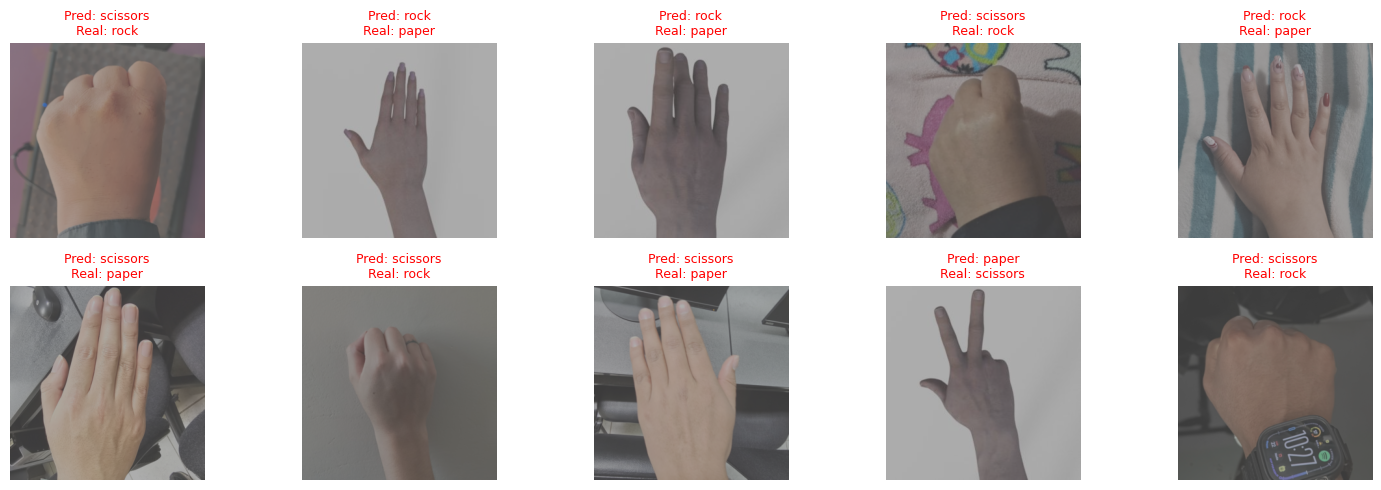

 Memoria liberada. Uso actual: 0.56 GB


In [15]:
def run_ann_search():
    # Espacio de búsqueda optimizado (Wide Search)
    grid = [
        {'bs': 32,  'dr': 0.2, 'lr': 1e-3}, # Configuración conservadora
        {'bs': 128, 'dr': 0.2, 'lr': 1e-3}, # Mayor throughput
        {'bs': 32,  'dr': 0.5, 'lr': 1e-3}, # Alta regularización
        {'bs': 128, 'dr': 0.5, 'lr': 1e-4}, # Ajuste fino con batch grande
    ]
    
    best_val_acc = 0
    best_config = None
    best_model_state = None
    best_time = 0

    print(f"🔎 Iniciando Grid Search para ANN ({len(grid)} configuraciones)...")
    
    for i, cfg in enumerate(grid):
        print(f"\n--- [ANN] Run {i+1}/{len(grid)}: BS={cfg['bs']}, Drop={cfg['dr']}, LR={cfg['lr']} ---")
        
        # 1. Crear DataLoaders (el batch size cambia)
        train_dl, valid_dl, test_dl, classes = get_dataloaders(
            TRAIN_PATH, VALID_PATH, TEST_PATH, 
            train_transform_scratch, valid_transform_scratch, cfg['bs']
        )
        
        # 2. Instanciar Modelo
        model = SimpleANN(dropout_rate=cfg['dr']).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
        criterion = nn.CrossEntropyLoss()
        
        # 3. Entrenar
        history, state, t_time = train_val_loop(
            model, train_dl, valid_dl, criterion, optimizer, 
            epochs=20, patience=5, name=f"ANN_r{i}"
        )
        
        # 4. Evaluar (usamos max val_acc como proxy de selección)
        max_acc = max(history['val_acc'])
        if max_acc > best_val_acc:
            best_val_acc = max_acc
            best_config = cfg
            best_model_state = state
            best_time = t_time
            
        # Limpieza intermedia
        del model, optimizer, criterion, train_dl, valid_dl, history
        clear_memory()

    print(f"\n🏆 Mejor Configuración ANN: {best_config} | Val Acc: {best_val_acc:.4f}")
    
    # --- Evaluación Final del Mejor Modelo ---
    print("re-cargando el mejor modelo para evaluación en Test...")
    final_model = SimpleANN(dropout_rate=best_config['dr']).to(DEVICE)
    final_model.load_state_dict(best_model_state)
    
    # DataLoaders para test
    _, _, test_dl, _ = get_dataloaders(TRAIN_PATH, VALID_PATH, TEST_PATH, 
                                       train_transform_scratch, valid_transform_scratch, 32)
    
    results = evaluate_with_tta(final_model, test_dl, use_tta=False) # TTA no ayuda mucho en MLPs planos
    results['training_time_s'] = best_time
    results['config'] = best_config
    results['best_val_acc'] = best_val_acc
    
    # Registrar globalmente
    register_result("1_ANN_Custom", results)
    
    # Visualizar errores
    show_error_examples(test_dl.dataset, results['predictions'], results['targets'], test_dl.dataset.classes)
    
    del final_model, test_dl
    clear_memory()

# Ejecutar Experimento
run_ann_search()

### 3.1.3 Visualización de entrenamiento 

💎 Mejor Configuración encontrada para 1_ANN_Custom: {'bs': 128, 'dr': 0.2, 'lr': 0.001}
📈 Generando curvas de aprendizaje para 1_ANN_Custom...
Iniciando entrenamiento: 1_ANN_Custom_PlotRun | Epochs: 15 | Patience: 5
Epoch [1/15] T.Loss: 0.7736 T.Acc: 0.6508 | V.Loss: 1.2129 V.Acc: 0.5349
Epoch [2/15] T.Loss: 0.4611 T.Acc: 0.8440 | V.Loss: 0.8388 V.Acc: 0.6425
Epoch [3/15] T.Loss: 0.2754 T.Acc: 0.9099 | V.Loss: 1.0796 V.Acc: 0.5860
Epoch [4/15] T.Loss: 0.1534 T.Acc: 0.9627 | V.Loss: 0.9096 V.Acc: 0.7769
Epoch [5/15] T.Loss: 0.1080 T.Acc: 0.9738 | V.Loss: 1.5842 V.Acc: 0.5376
Epoch [6/15] T.Loss: 0.0780 T.Acc: 0.9813 | V.Loss: 1.3754 V.Acc: 0.5457
Epoch [7/15] T.Loss: 0.0569 T.Acc: 0.9857 | V.Loss: 1.1218 V.Acc: 0.6559
Epoch [8/15] T.Loss: 0.0423 T.Acc: 0.9897 | V.Loss: 1.9598 V.Acc: 0.4005
Epoch [9/15] T.Loss: 0.0384 T.Acc: 0.9897 | V.Loss: 1.7669 V.Acc: 0.6183
	Early stopping activado en época 9
	->Tiempo total de entrenamiento: 230.08s


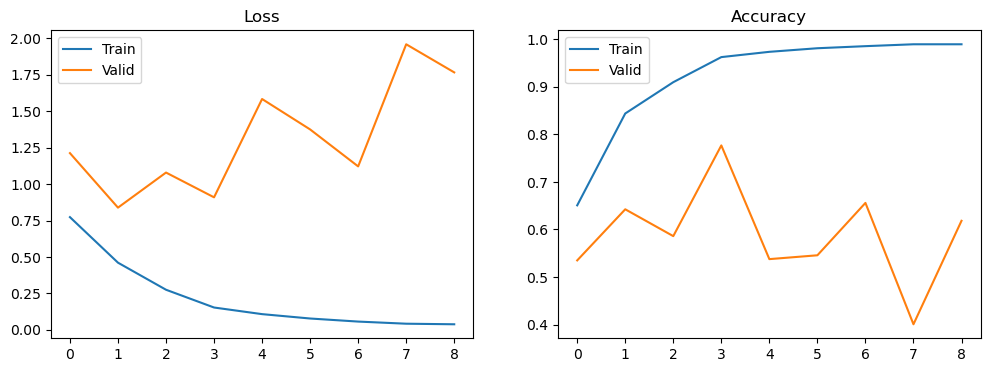

 Memoria liberada. Uso actual: 0.41 GB


In [18]:
# --- Ejecutar Visualización ---

# 1. Visualizar Mejor ANN
visualize_best_model("1_ANN_Custom", SimpleANN, train_transform_scratch, valid_transform_scratch)

## 3.2 CNN (diseño propio)

### 3.2.1 Arquitectura

In [24]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.2, use_batchnorm=True, 
                 base_filters=32):
        super(CustomCNN, self).__init__()
        
        def conv_block(in_channels, out_channels):
            layers = []
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(out_channels, out_channels, 3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            layers.append(nn.Dropout(dropout_rate))
            return nn.Sequential(*layers)
        
        self.conv1 = conv_block(3, base_filters)
        self.conv2 = conv_block(base_filters, base_filters * 2)
        self.conv3 = conv_block(base_filters * 2, base_filters * 4)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(base_filters * 4, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

dummy_cnn = CustomCNN()
print(f"📊 Parámetros CustomCNN: {count_parameters(dummy_cnn)[0]:,}")
del dummy_cnn

📊 Parámetros CustomCNN: 288,291


### 3.2.2 Entrenamiento

🔎 Iniciando Grid Search para CustomCNN (4 configuraciones)...

--- [CNN] Run 1/4: BS=32, Filt=16, Drop=0.2 ---
Iniciando entrenamiento: CNN_r0 | Epochs: 25 | Patience: 6
Epoch [1/25] T.Loss: 0.9993 T.Acc: 0.4948 | V.Loss: 0.9469 V.Acc: 0.6263
Epoch [2/25] T.Loss: 0.9074 T.Acc: 0.5948 | V.Loss: 0.8430 V.Acc: 0.7016
Epoch [3/25] T.Loss: 0.8032 T.Acc: 0.6679 | V.Loss: 0.7253 V.Acc: 0.6720
Epoch [4/25] T.Loss: 0.7145 T.Acc: 0.7143 | V.Loss: 0.9682 V.Acc: 0.3844
Epoch [5/25] T.Loss: 0.6456 T.Acc: 0.7627 | V.Loss: 0.5679 V.Acc: 0.9220
Epoch [6/25] T.Loss: 0.5592 T.Acc: 0.8087 | V.Loss: 0.7518 V.Acc: 0.6129
Epoch [7/25] T.Loss: 0.5202 T.Acc: 0.8151 | V.Loss: 0.4388 V.Acc: 0.9167
Epoch [8/25] T.Loss: 0.4657 T.Acc: 0.8433 | V.Loss: 0.5353 V.Acc: 0.8199
Epoch [9/25] T.Loss: 0.4280 T.Acc: 0.8615 | V.Loss: 0.4854 V.Acc: 0.8495
Epoch [10/25] T.Loss: 0.3948 T.Acc: 0.8806 | V.Loss: 5.9703 V.Acc: 0.3844
Epoch [11/25] T.Loss: 0.3804 T.Acc: 0.8758 | V.Loss: 0.6552 V.Acc: 0.6828
	Early stopping activado 

,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,0.539683,0.779221,0.534848,0.488977,187.209493,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1121.483709,"{'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}",0.943548
3_Transfer_ResNet,None,None,None,None,None,None,None,None,None,None
4_SqueezeNet,None,None,None,None,None,None,None,None,None,None
5_DenseNet,None,None,None,None,None,None,None,None,None,None


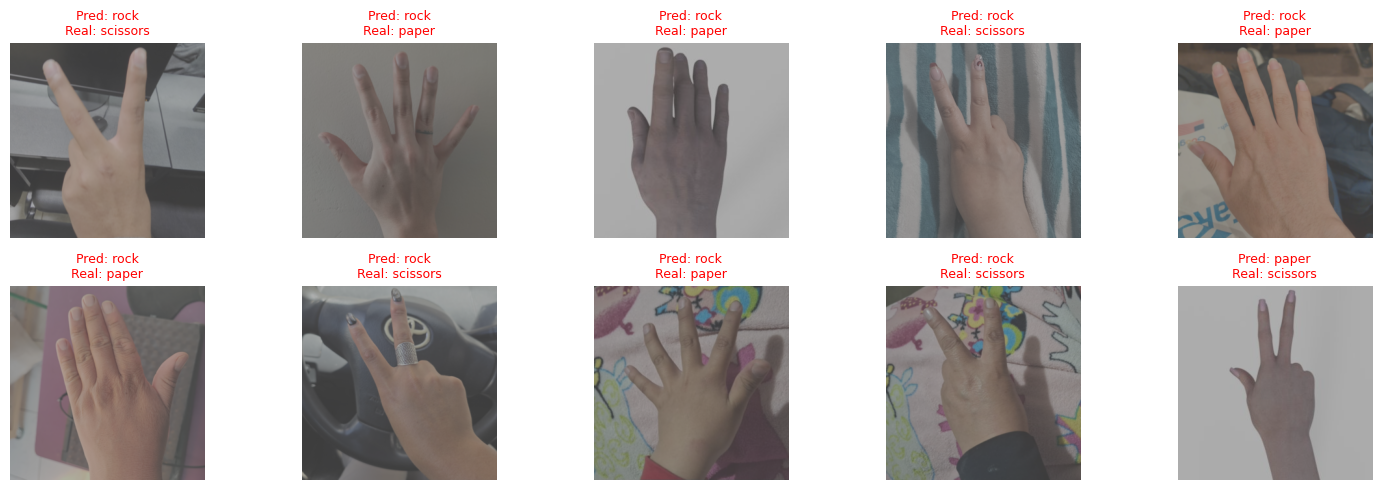

 Memoria liberada. Uso actual: 0.52 GB


In [25]:
def run_cnn_search():
    # Grid Search optimizado
    grid = [
        {'bs': 32, 'filters': 16, 'dr': 0.2, 'lr': 1e-3}, # Modelo ligero
        {'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 1e-3}, # Modelo estándar (Base)
        {'bs': 64, 'filters': 32, 'dr': 0.5, 'lr': 1e-3}, # Mayor regularización y batch
        {'bs': 64, 'filters': 64, 'dr': 0.2, 'lr': 1e-4}, # Modelo pesado, LR bajo
    ]
    
    best_val_acc = 0
    best_config = None
    best_model_state = None
    best_time = 0

    print(f"🔎 Iniciando Grid Search para CustomCNN ({len(grid)} configuraciones)...")
    
    for i, cfg in enumerate(grid):
        print(f"\n--- [CNN] Run {i+1}/{len(grid)}: BS={cfg['bs']}, Filt={cfg['filters']}, Drop={cfg['dr']} ---")
        
        train_dl, valid_dl, test_dl, classes = get_dataloaders(
            TRAIN_PATH, VALID_PATH, TEST_PATH, 
            train_transform_scratch, valid_transform_scratch, cfg['bs']
        )
        
        model = CustomCNN(dropout_rate=cfg['dr'], base_filters=cfg['filters']).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
        criterion = nn.CrossEntropyLoss()
        
        history, state, t_time = train_val_loop(
            model, train_dl, valid_dl, criterion, optimizer, 
            epochs=25, patience=6, name=f"CNN_r{i}"
        )
        
        max_acc = max(history['val_acc'])
        if max_acc > best_val_acc:
            best_val_acc = max_acc
            best_config = cfg
            best_model_state = state
            best_time = t_time
            
        del model, optimizer, criterion, train_dl, valid_dl, history
        clear_memory()

    print(f"\n🏆 Mejor Configuración CNN: {best_config} | Val Acc: {best_val_acc:.4f}")
    
    # --- Evaluación Final ---
    final_model = CustomCNN(dropout_rate=best_config['dr'], base_filters=best_config['filters']).to(DEVICE)
    final_model.load_state_dict(best_model_state)
    
    _, _, test_dl, _ = get_dataloaders(TRAIN_PATH, VALID_PATH, TEST_PATH, 
                                       train_transform_scratch, valid_transform_scratch, 32)
    
    # Usamos TTA aquí, las CNNs se benefician más de las transformaciones espaciales
    results = evaluate_with_tta(final_model, test_dl, use_tta=True) 
    results['training_time_s'] = best_time
    results['config'] = best_config
    results['best_val_acc'] = best_val_acc
    
    register_result("2_CNN_Custom", results)
    
    show_error_examples(test_dl.dataset, results['predictions'], results['targets'], test_dl.dataset.classes)
    
    del final_model, test_dl
    clear_memory()

run_cnn_search()

### 3.2.3 Visualización de entrenamiento

💎 Mejor Configuración encontrada para 2_CNN_Custom: {'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}
📈 Generando curvas de aprendizaje para 2_CNN_Custom...
Iniciando entrenamiento: 2_CNN_Custom_PlotRun | Epochs: 15 | Patience: 5


/opt/homebrew/Caskroom/miniforge/base/envs/dl_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15] T.Loss: 0.9641 T.Acc: 0.5413 | V.Loss: 0.8595 V.Acc: 0.7097
Epoch [2/15] T.Loss: 0.8038 T.Acc: 0.6730 | V.Loss: 0.7166 V.Acc: 0.7070
Epoch [3/15] T.Loss: 0.6659 T.Acc: 0.7603 | V.Loss: 3.6819 V.Acc: 0.3333
Epoch [4/15] T.Loss: 0.5407 T.Acc: 0.8294 | V.Loss: 1.1467 V.Acc: 0.6317
Epoch [5/15] T.Loss: 0.4545 T.Acc: 0.8683 | V.Loss: 1.3259 V.Acc: 0.5860
Epoch [6/15] T.Loss: 0.3976 T.Acc: 0.8841 | V.Loss: 0.8952 V.Acc: 0.4597
	Early stopping activado en época 6
	->Tiempo total de entrenamiento: 264.41s


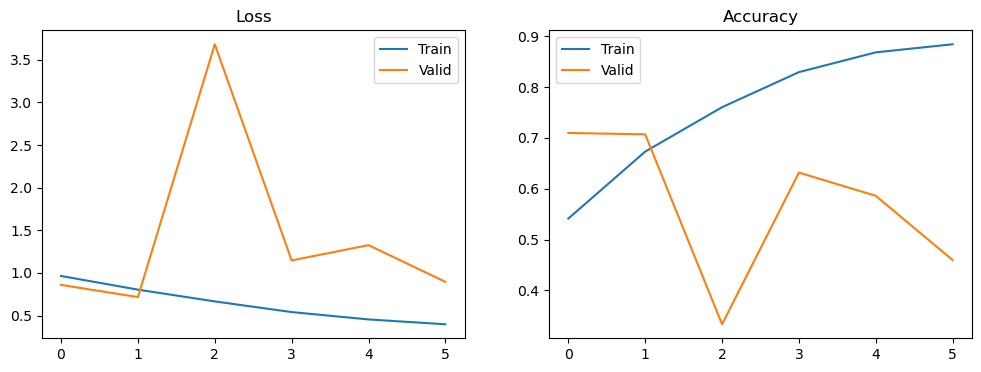

 Memoria liberada. Uso actual: 0.58 GB


In [26]:
visualize_best_model("2_CNN_Custom", CustomCNN, train_transform_scratch, valid_transform_scratch)

## 3.3 Transfer Learning (NEW)

In [59]:
# Estadísticas oficiales de ImageNet
IMAGENET_STATS = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

# Transformación de entrenamiento V2 (Compleja/Agresiva)
train_transform_imagenet_v2 = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45), 
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  
    transforms.ToTensor(),
    # Asumimos que ReplaceWhiteBackground está definido en la Sección 1. Si no, comentar la línea de abajo.
    ReplaceWhiteBackground(threshold=0.9, p=0.3, noise_type='color'), 
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])

# Transformación de validación/test estándar
valid_transform_imagenet = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])

🚀 Iniciando experimentos ResNet (3 configs)...

--- [ResNet] Exp 1: ResNet_HeadOnly | Mode: head_only | LR: 0.001 ---
Iniciando entrenamiento: ResNet_HeadOnly | Epochs: 20 | Patience: 5
Epoch [1/20] T.Loss: 1.1098 T.Acc: 0.4028 | V.Loss: 1.0217 V.Acc: 0.6613
Epoch [2/20] T.Loss: 1.0297 T.Acc: 0.4885 | V.Loss: 0.9086 V.Acc: 0.9355
Epoch [3/20] T.Loss: 0.9906 T.Acc: 0.5282 | V.Loss: 0.8668 V.Acc: 0.7688
Epoch [4/20] T.Loss: 0.9653 T.Acc: 0.5544 | V.Loss: 0.8360 V.Acc: 0.6694
Epoch [5/20] T.Loss: 0.9319 T.Acc: 0.5976 | V.Loss: 0.7505 V.Acc: 0.9247
Epoch [6/20] T.Loss: 0.9319 T.Acc: 0.5952 | V.Loss: 0.7802 V.Acc: 0.9516
Epoch [7/20] T.Loss: 0.9406 T.Acc: 0.5778 | V.Loss: 0.7967 V.Acc: 0.9435
Epoch [8/20] T.Loss: 0.9324 T.Acc: 0.6163 | V.Loss: 0.7802 V.Acc: 0.9328
Epoch [9/20] T.Loss: 0.9336 T.Acc: 0.5937 | V.Loss: 0.7448 V.Acc: 0.9516
Epoch [10/20] T.Loss: 0.9198 T.Acc: 0.6048 | V.Loss: 0.7035 V.Acc: 0.9247
Epoch [11/20] T.Loss: 0.9151 T.Acc: 0.6071 | V.Loss: 0.7313 V.Acc: 0.9435
	Early st

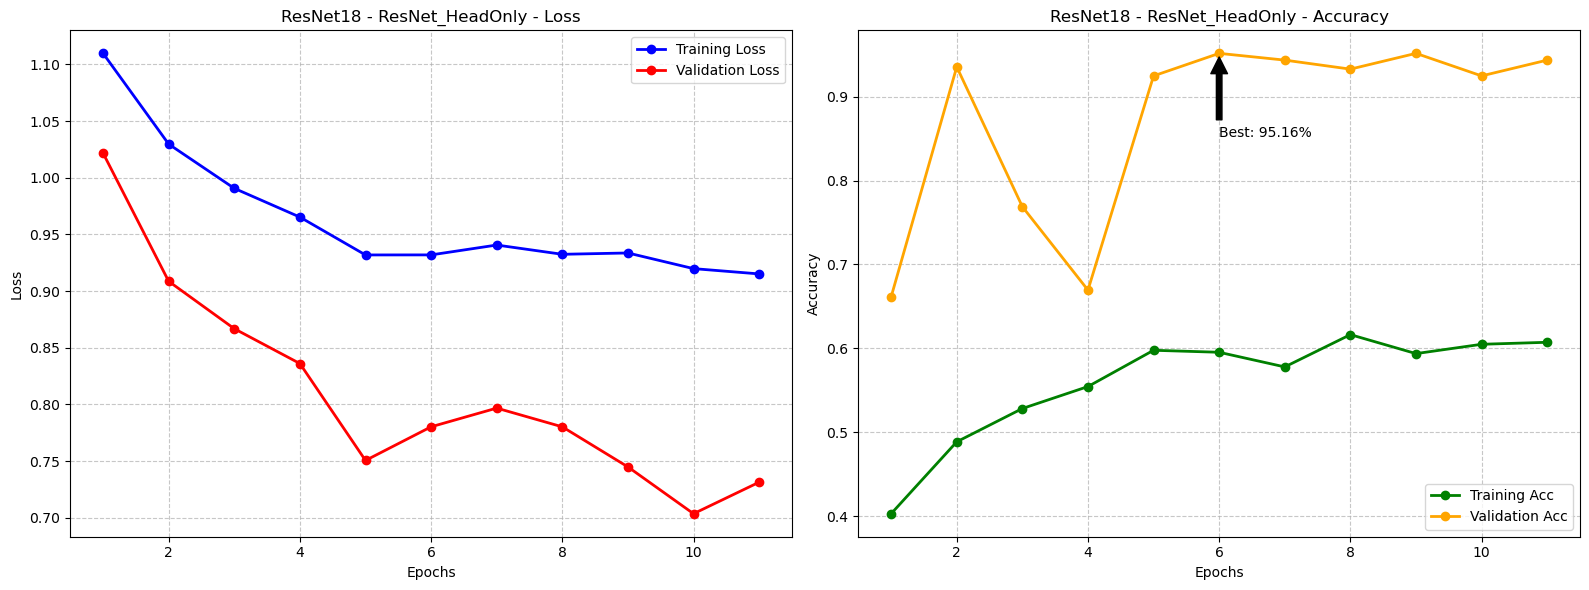

💾 Nuevo mejor modelo guardado en checkpoints/3_Transfer_ResNet_best.pt (Acc: 0.9516)
📝 Registrando resultados para: 3_Transfer_ResNet


,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,0.539683,0.779221,0.534848,0.488977,187.209493,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1121.483709,"{'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}",0.943548
3_Transfer_ResNet,0.761905,0.776181,0.756999,0.757164,8.930108,"[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",160.430242,"{'name': 'ResNet_HeadOnly', 'mode': 'head_only...",NaN
4_SqueezeNet,None,None,None,None,None,None,None,None,None,None
5_DenseNet,None,None,None,None,None,None,None,None,None,None


 Memoria liberada. Uso actual: 0.92 GB

--- [ResNet] Exp 2: ResNet_FineTune_L4 | Mode: fine_tune_layer4 | LR: 0.0001 ---
Iniciando entrenamiento: ResNet_FineTune_L4 | Epochs: 20 | Patience: 5


/opt/homebrew/Caskroom/miniforge/base/envs/dl_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] T.Loss: 0.9126 T.Acc: 0.6052 | V.Loss: 0.4856 V.Acc: 0.9140
Epoch [2/20] T.Loss: 0.5073 T.Acc: 0.9075 | V.Loss: 0.4519 V.Acc: 0.8871
Epoch [3/20] T.Loss: 0.4370 T.Acc: 0.9456 | V.Loss: 0.5008 V.Acc: 0.8602
Epoch [4/20] T.Loss: 0.4147 T.Acc: 0.9603 | V.Loss: 0.3921 V.Acc: 0.9489
Epoch [5/20] T.Loss: 0.4062 T.Acc: 0.9623 | V.Loss: 0.5472 V.Acc: 0.8602
Epoch [6/20] T.Loss: 0.3886 T.Acc: 0.9718 | V.Loss: 0.4674 V.Acc: 0.8710
Epoch [7/20] T.Loss: 0.3862 T.Acc: 0.9738 | V.Loss: 0.4403 V.Acc: 0.9194
Epoch [8/20] T.Loss: 0.3826 T.Acc: 0.9714 | V.Loss: 0.5657 V.Acc: 0.8387
Epoch [9/20] T.Loss: 0.3742 T.Acc: 0.9774 | V.Loss: 0.4185 V.Acc: 0.9328
	Early stopping activado en época 9
	->Tiempo total de entrenamiento: 154.68s


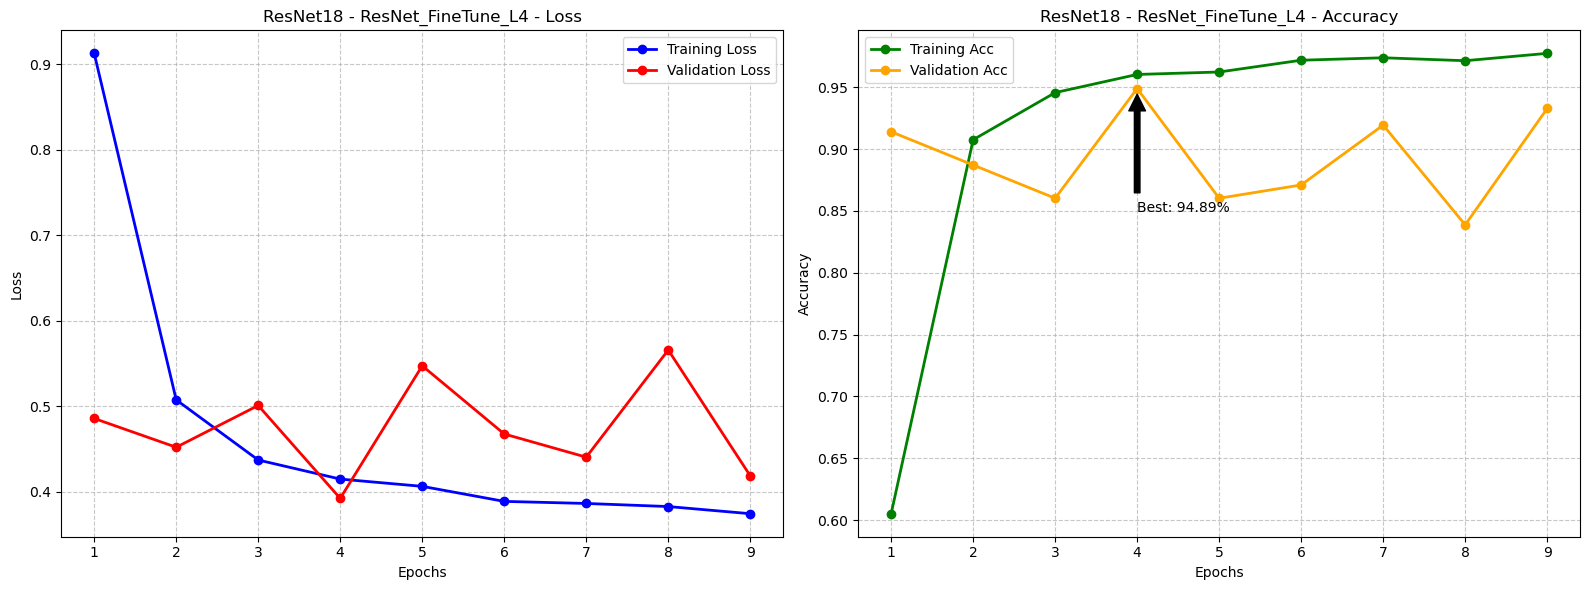

 Memoria liberada. Uso actual: 0.96 GB

--- [ResNet] Exp 3: ResNet_DeepTune_Orig | Mode: fine_tune_deep | LR: 0.0001 ---
Iniciando entrenamiento: ResNet_DeepTune_Orig | Epochs: 20 | Patience: 5
Epoch [1/20] T.Loss: 0.8217 T.Acc: 0.6659 | V.Loss: 0.4821 V.Acc: 0.8683
Epoch [2/20] T.Loss: 0.4463 T.Acc: 0.9397 | V.Loss: 0.4201 V.Acc: 0.9597
Epoch [3/20] T.Loss: 0.4048 T.Acc: 0.9639 | V.Loss: 0.3546 V.Acc: 0.9919
Epoch [4/20] T.Loss: 0.3841 T.Acc: 0.9710 | V.Loss: 0.3099 V.Acc: 1.0000
Epoch [5/20] T.Loss: 0.3836 T.Acc: 0.9687 | V.Loss: 0.3063 V.Acc: 1.0000
Epoch [6/20] T.Loss: 0.3667 T.Acc: 0.9798 | V.Loss: 0.4051 V.Acc: 0.9328
Epoch [7/20] T.Loss: 0.3654 T.Acc: 0.9806 | V.Loss: 0.4052 V.Acc: 0.9462
Epoch [8/20] T.Loss: 0.3531 T.Acc: 0.9861 | V.Loss: 0.3359 V.Acc: 0.9866
Epoch [9/20] T.Loss: 0.3569 T.Acc: 0.9833 | V.Loss: 0.3413 V.Acc: 0.9839
	Early stopping activado en época 9
	->Tiempo total de entrenamiento: 176.02s


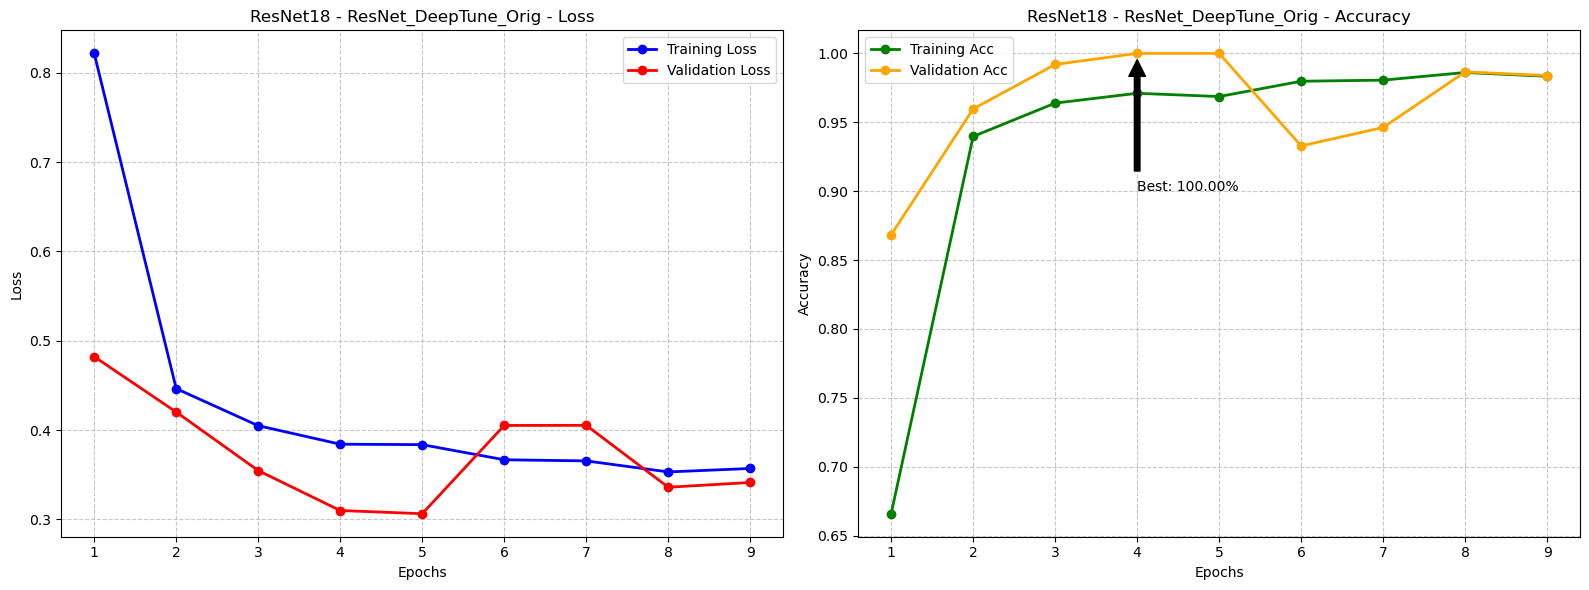

💾 Nuevo mejor modelo guardado en checkpoints/3_Transfer_ResNet_best.pt (Acc: 1.0000)
📝 Registrando resultados para: 3_Transfer_ResNet


,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,0.539683,0.779221,0.534848,0.488977,187.209493,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1121.483709,"{'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}",0.943548
3_Transfer_ResNet,0.84127,0.856662,0.837879,0.834447,8.918751,"[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",176.021904,"{'name': 'ResNet_DeepTune_Orig', 'mode': 'fine...",NaN
4_SqueezeNet,None,None,None,None,None,None,None,None,None,None
5_DenseNet,None,None,None,None,None,None,None,None,None,None


 Memoria liberada. Uso actual: 0.99 GB

🏆 Mejor Experimento ResNet: ResNet_DeepTune_Orig | Val Acc: 1.0000


In [60]:
def run_resnet_experiments():
    # Definimos los escenarios a comparar
    experiments = [
        # Exp 1: Feature Extraction (Solo entrena el clasificador)
        {
            'name': 'ResNet_HeadOnly',
            'mode': 'head_only',
            'bs': 32,
            'lr': 1e-3, 
            'dr': 0.6
        },
        # Exp 2: Fine Tuning (Layer 4 + FC)
        {
            'name': 'ResNet_FineTune_L4',
            'mode': 'fine_tune_layer4',
            'bs': 32,
            'lr': 1e-4, 
            'dr': 0.6
        },
        # Exp 3: Fine Tuning Profundo (Lógica original notebook)
        {
            'name': 'ResNet_DeepTune_Orig',
            'mode': 'fine_tune_deep',
            'bs': 32,
            'lr': 1e-4, 
            'dr': 0.6
        }
    ]
    
    best_val_acc_global = 0.0
    best_model_name = ""
    
    print(f"🚀 Iniciando experimentos ResNet ({len(experiments)} configs)...")

    for i, cfg in enumerate(experiments):
        print(f"\n--- [ResNet] Exp {i+1}: {cfg['name']} | Mode: {cfg['mode']} | LR: {cfg['lr']} ---")
        
        # 1. DataLoaders (Ahora usarán num_workers=0)
        train_dl, valid_dl, test_dl, classes = get_dataloaders(
            TRAIN_PATH, VALID_PATH, TEST_PATH, 
            train_transform_imagenet_v2, valid_transform_imagenet, cfg['bs']
        )
        
        # 2. Modelo
        model = TransferLearningCNN(
            dropout_rate=cfg['dr'], 
            fine_tune_mode=cfg['mode']
        ).to(DEVICE)
        
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # 3. Entrenar
        history, state, t_time = train_val_loop(
            model, train_dl, valid_dl, criterion, optimizer, 
            epochs=20, patience=5, name=cfg['name']
        )
        
        # Visualizar métricas inmediatamente
        plot_metrics(history, title=f"ResNet18 - {cfg['name']}")
        
        # 4. Chequear si es el mejor absoluto
        current_acc = max(history['val_acc'])
        if current_acc > best_val_acc_global:
            best_val_acc_global = current_acc
            best_model_name = cfg['name']
            
            # GUARDADO ESTILO ORIGINAL (Solo .pt)
            save_path = CHECKPOINT_PATH / "3_Transfer_ResNet_best.pt"
            torch.save(state, save_path)
            print(f"💾 Nuevo mejor modelo guardado en {save_path} (Acc: {current_acc:.4f})")
            
            # Registrar resultado
            model.load_state_dict(state)
            # Usar TTA
            res = evaluate_with_tta(model, test_dl, use_tta=True)
            res['config'] = cfg
            res['training_time_s'] = t_time
            register_result("3_Transfer_ResNet", res)
            
        del model, optimizer, criterion, train_dl, valid_dl
        clear_memory()
        
    print(f"\n🏆 Mejor Experimento ResNet: {best_model_name} | Val Acc: {best_val_acc_global:.4f}")

# Ejecutar nuevamente
run_resnet_experiments()

### Ejemplo de aplicación de las transformaciones

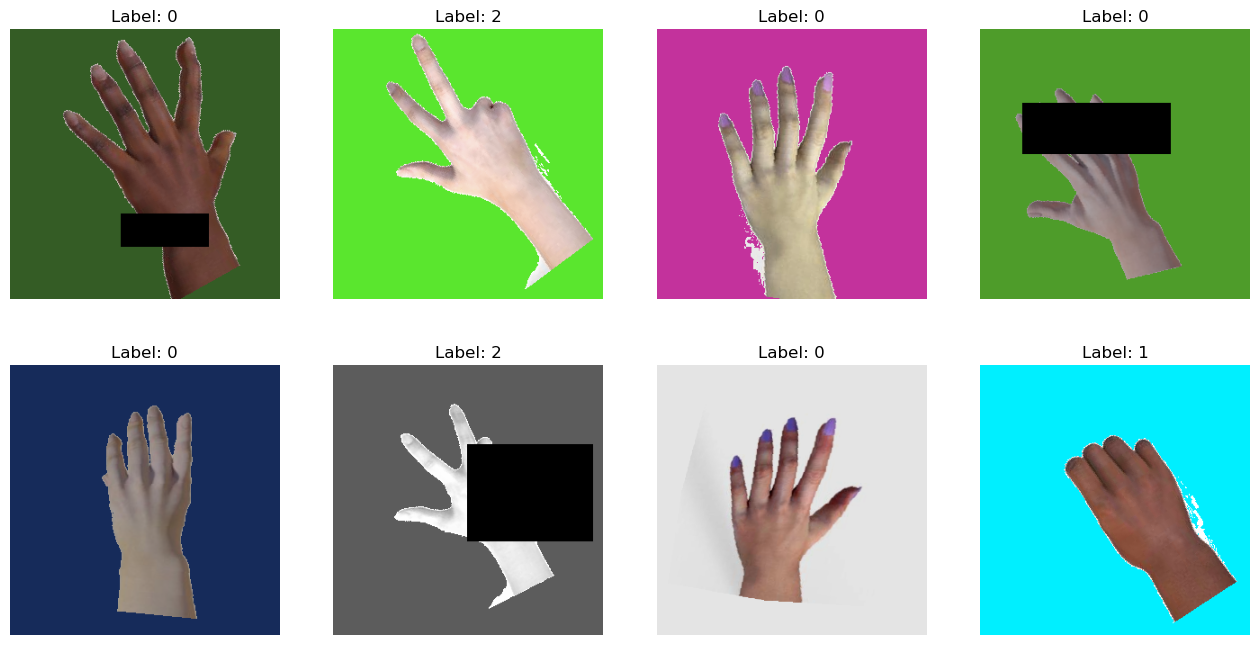

In [438]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to un-normalize and display
def show_batch(dataloader):
    # Get one batch
    images, labels = next(iter(dataloader))
    
    plt.figure(figsize=(16, 8))
    for i in range(min(8, len(images))): # Show top 8 images
        ax = plt.subplot(2, 4, i + 1)
        
        # Undo normalization for display: img = img * std + mean
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Clip to valid range
        
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

# Assuming you have your train_loader defined
show_batch(train_loader)

In [599]:
clear_memory()

Memory after cleanup: 11.86 GB


## 3.6 CNN (arquitectura SqueezeNetV1)

### 3.6.1 Arquitectura

Se usa la arquitectura que ya está en pytorch de mobilenet large

In [70]:
# Definición de la transformación "v2_simplified" del notebook original
train_transform_imagenet_v2_simplified = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45, fill=255), 
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, fill=255),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    # Asumimos ReplaceWhiteBackground definida en Sección 1
    ReplaceWhiteBackground(threshold=0.9, p=0.7, noise_type='color'),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [71]:
class Fire(nn.Module):
    """Módulo Fire estándar requerido por SqueezeNet."""
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNetScratch(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1 + MaxPool1
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is self.classifier[1]:
                    nn.init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

dummy_sq = SqueezeNetScratch()
print(f"📊 Parámetros SqueezeNet: {count_parameters(dummy_sq)[0]:,}")
del dummy_sq

📊 Parámetros SqueezeNet: 724,035


🚀 Iniciando Búsqueda SqueezeNet (3 configs)...

--- [SqueezeNet] Run 1: SQ_Original (Baseline (High BS, Moderate LR)) ---
Iniciando entrenamiento: SQ_Original | Epochs: 25 | Patience: 8
Epoch [1/25] T.Loss: 1.0953 T.Acc: 0.3619 | V.Loss: 1.0983 V.Acc: 0.3333
Epoch [2/25] T.Loss: 1.0942 T.Acc: 0.3802 | V.Loss: 1.0936 V.Acc: 0.3333
Epoch [3/25] T.Loss: 1.0413 T.Acc: 0.4758 | V.Loss: 0.9667 V.Acc: 0.5995
Epoch [4/25] T.Loss: 0.8881 T.Acc: 0.6468 | V.Loss: 0.7672 V.Acc: 0.6452
Epoch [5/25] T.Loss: 0.8051 T.Acc: 0.7131 | V.Loss: 0.6725 V.Acc: 0.8280
Epoch [6/25] T.Loss: 0.7716 T.Acc: 0.7452 | V.Loss: 0.7295 V.Acc: 0.6613
Epoch [7/25] T.Loss: 0.7072 T.Acc: 0.7952 | V.Loss: 0.7210 V.Acc: 0.6935
Epoch [8/25] T.Loss: 0.6920 T.Acc: 0.8131 | V.Loss: 0.5527 V.Acc: 0.8871
Epoch [9/25] T.Loss: 0.6602 T.Acc: 0.8317 | V.Loss: 0.5568 V.Acc: 0.9005
Epoch [10/25] T.Loss: 0.6170 T.Acc: 0.8595 | V.Loss: 0.5198 V.Acc: 0.9624
Epoch [11/25] T.Loss: 0.5880 T.Acc: 0.8782 | V.Loss: 0.5030 V.Acc: 0.9489
Epoch [12

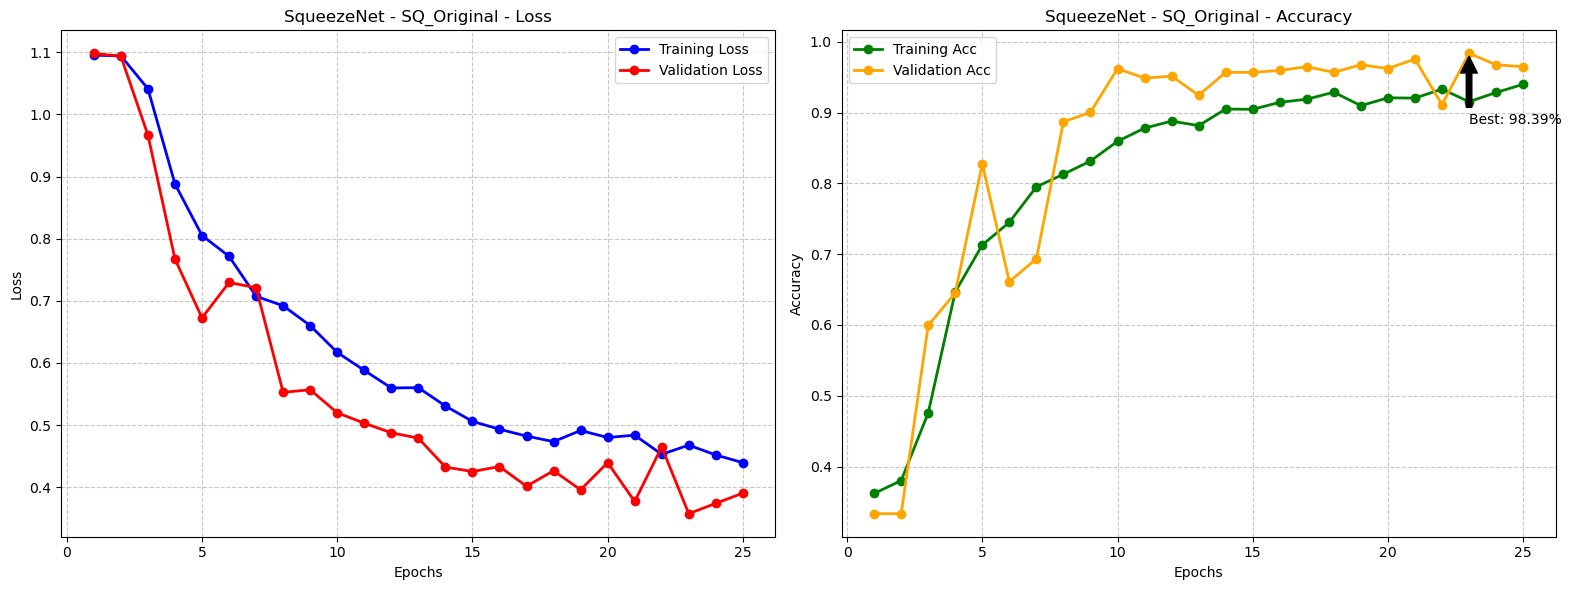

💾 ¡Nuevo Récord! Modelo guardado en checkpoints/4_SqueezeNet_best.pt (Acc: 0.9839)
📝 Registrando resultados para: 4_SqueezeNet


,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,0.539683,0.779221,0.534848,0.488977,187.209493,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1121.483709,"{'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}",0.943548
3_Transfer_ResNet,0.84127,0.856662,0.837879,0.834447,8.918751,"[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",176.021904,"{'name': 'ResNet_DeepTune_Orig', 'mode': 'fine...",NaN
4_SqueezeNet,0.793651,0.802994,0.788745,0.785799,7.372542,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",399.557929,"{'name': 'SQ_Original', 'bs': 32, 'lr': 0.0001...",NaN
5_DenseNet,None,None,None,None,None,None,None,None,None,None


 Memoria liberada. Uso actual: 1.11 GB

--- [SqueezeNet] Run 2: SQ_Stable (Lower LR & Batch (Stability focus)) ---
Iniciando entrenamiento: SQ_Stable | Epochs: 25 | Patience: 8


/opt/homebrew/Caskroom/miniforge/base/envs/dl_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/25] T.Loss: 1.0996 T.Acc: 0.3333 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [2/25] T.Loss: 1.0984 T.Acc: 0.3599 | V.Loss: 1.0985 V.Acc: 0.4489
Epoch [3/25] T.Loss: 1.0920 T.Acc: 0.3750 | V.Loss: 1.0787 V.Acc: 0.4839
Epoch [4/25] T.Loss: 1.0506 T.Acc: 0.4635 | V.Loss: 1.0673 V.Acc: 0.3898
Epoch [5/25] T.Loss: 0.9654 T.Acc: 0.5627 | V.Loss: 0.7788 V.Acc: 0.6613
Epoch [6/25] T.Loss: 0.9057 T.Acc: 0.6258 | V.Loss: 0.7181 V.Acc: 0.7715
Epoch [7/25] T.Loss: 0.8137 T.Acc: 0.6988 | V.Loss: 0.6541 V.Acc: 0.8844
Epoch [8/25] T.Loss: 0.7810 T.Acc: 0.7433 | V.Loss: 0.7274 V.Acc: 0.6989
Epoch [9/25] T.Loss: 0.7532 T.Acc: 0.7718 | V.Loss: 0.5676 V.Acc: 0.9113
Epoch [10/25] T.Loss: 0.7232 T.Acc: 0.7722 | V.Loss: 0.6504 V.Acc: 0.7554
Epoch [11/25] T.Loss: 0.6952 T.Acc: 0.8123 | V.Loss: 0.6111 V.Acc: 0.8118
Epoch [12/25] T.Loss: 0.6502 T.Acc: 0.8429 | V.Loss: 0.5042 V.Acc: 0.9489
Epoch [13/25] T.Loss: 0.6266 T.Acc: 0.8524 | V.Loss: 0.5148 V.Acc: 0.9301
Epoch [14/25] T.Loss: 0.5961 T.Acc: 0.8659 | V.

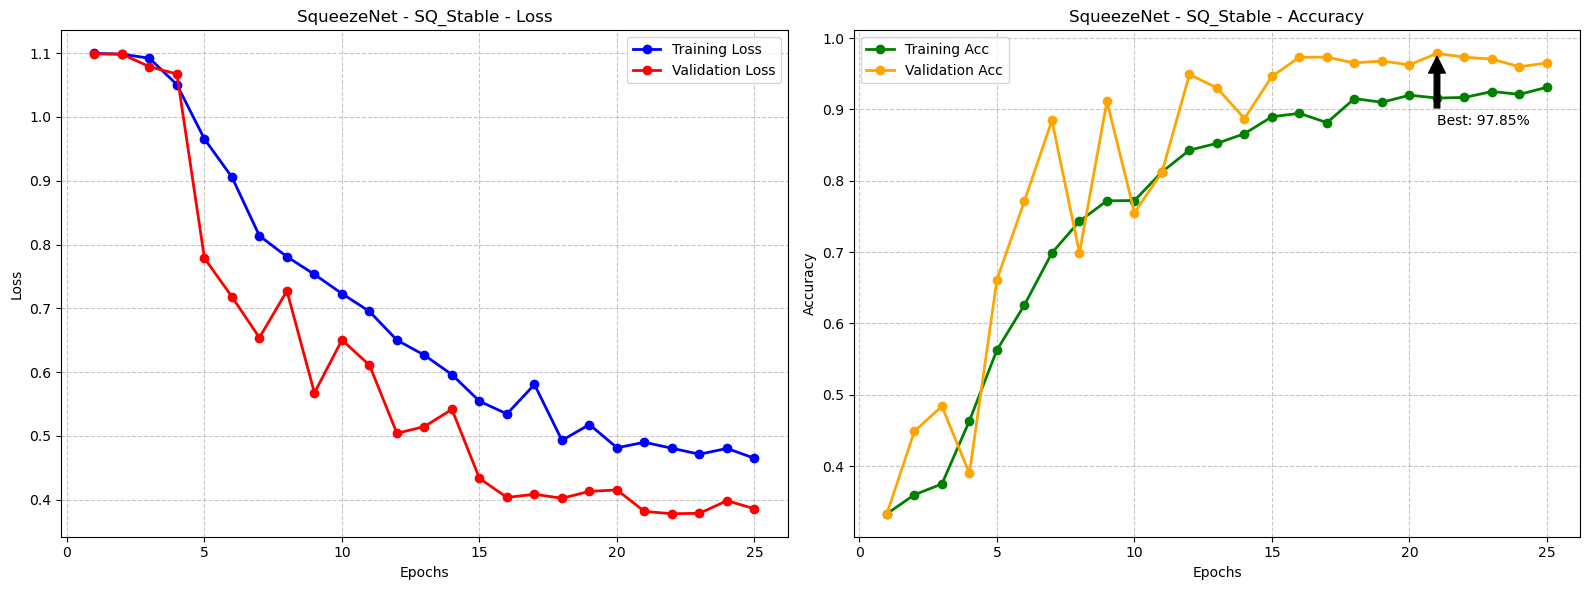

 Memoria liberada. Uso actual: 1.33 GB

--- [SqueezeNet] Run 3: SQ_LowDrop (Low Dropout (Fast Learning)) ---
Iniciando entrenamiento: SQ_LowDrop | Epochs: 25 | Patience: 8
Epoch [1/25] T.Loss: 1.0994 T.Acc: 0.3413 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [2/25] T.Loss: 1.0986 T.Acc: 0.3302 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [3/25] T.Loss: 1.0986 T.Acc: 0.3266 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [4/25] T.Loss: 1.0986 T.Acc: 0.3317 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [5/25] T.Loss: 1.0986 T.Acc: 0.3329 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [6/25] T.Loss: 1.0986 T.Acc: 0.3349 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [7/25] T.Loss: 1.0986 T.Acc: 0.3310 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [8/25] T.Loss: 1.0986 T.Acc: 0.3345 | V.Loss: 1.0986 V.Acc: 0.3333
Epoch [9/25] T.Loss: 1.0986 T.Acc: 0.3333 | V.Loss: 1.0986 V.Acc: 0.3333
	Early stopping activado en época 9
	->Tiempo total de entrenamiento: 141.64s


/var/folders/pr/nd_8dmzs5hz4113qfh29myrc0000gn/T/ipykernel_31103/3629081061.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


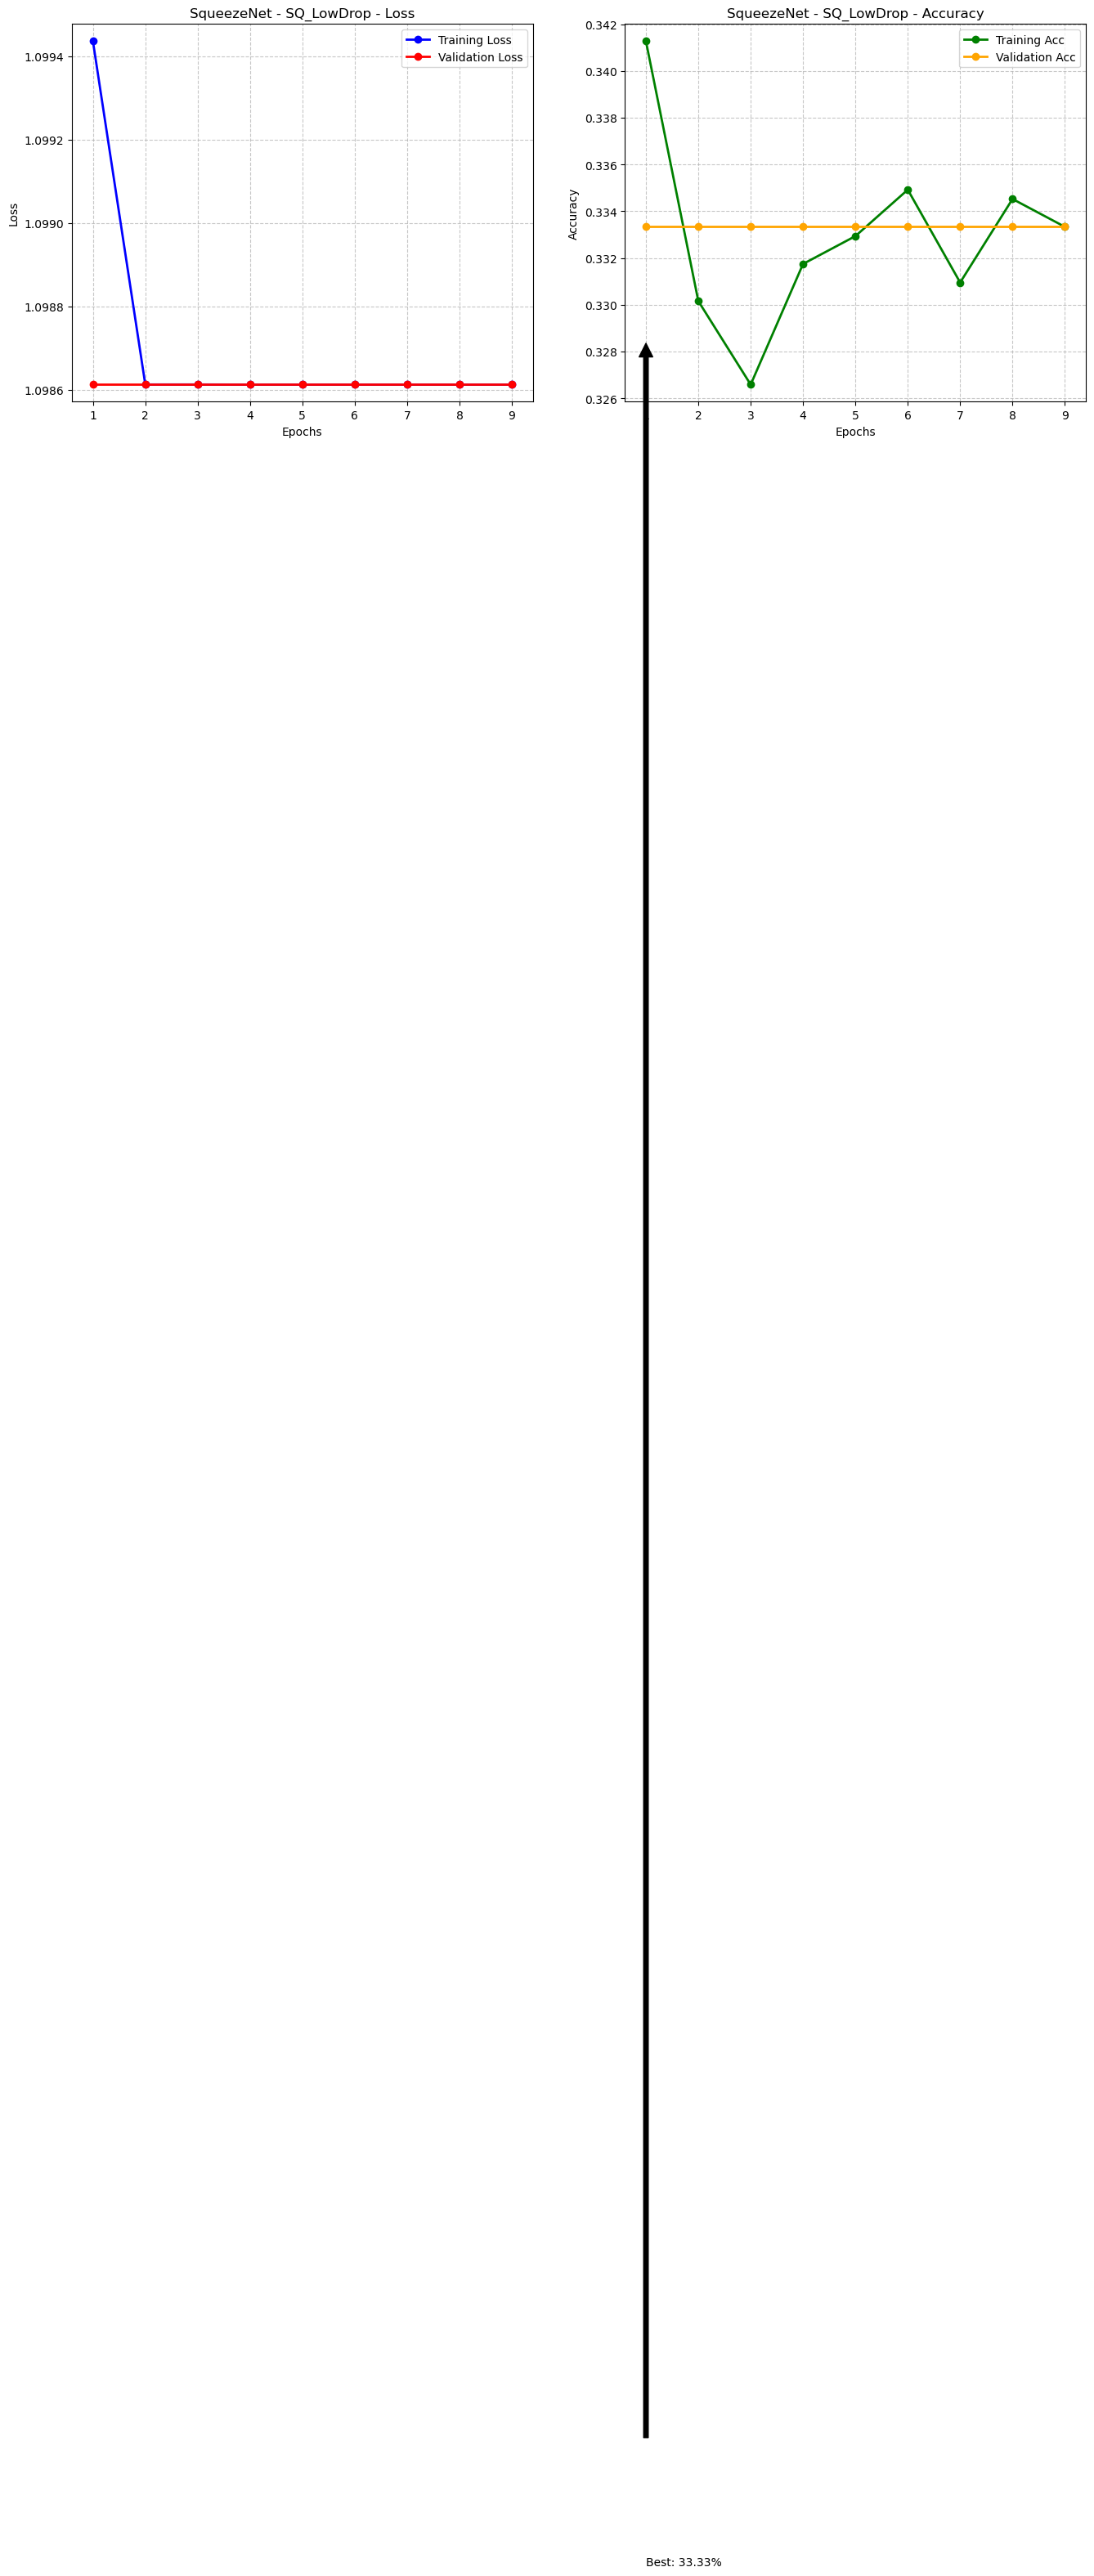

 Memoria liberada. Uso actual: 1.35 GB

🏆 Mejor SqueezeNet: SQ_Original | Val Acc: 0.9839


In [73]:
def run_squeezenet_search():
    # Definimos 3 configuraciones para explorar
    experiments = [
        # 1. Configuración Original (Notebook)
        {
            'name': 'SQ_Original',
            'bs': 32, 
            'lr': 1e-4, 
            'dr': 0.5,
            'desc': 'Baseline (High BS, Moderate LR)'
        },
        # 2. Configuración Conservadora (Más estable)
        {
            'name': 'SQ_Stable',
            'bs': 64, 
            'lr': 1e-4, 
            'dr': 0.5,
            'desc': 'Lower LR & Batch (Stability focus)'
        },
        # 3. Configuración "Agresiva" (Menos regularización)
        {
            'name': 'SQ_LowDrop',
            'bs': 64, 
            'lr': 3e-4, 
            'dr': 0.2, # Menos Dropout
            'desc': 'Low Dropout (Fast Learning)'
        }
    ]
    
    best_val_acc_global = 0.0
    best_model_name = ""
    
    print(f"🚀 Iniciando Búsqueda SqueezeNet ({len(experiments)} configs)...")

    for i, cfg in enumerate(experiments):
        print(f"\n--- [SqueezeNet] Run {i+1}: {cfg['name']} ({cfg['desc']}) ---")
        
        # 1. DataLoaders (Ajustando Batch Size dinámicamente)
        # Usamos try-except para reducir batch si la VRAM no aguanta 128
        try:
            train_dl, valid_dl, test_dl, classes = get_dataloaders(
                TRAIN_PATH, VALID_PATH, TEST_PATH, 
                train_transform_imagenet_v2_simplified, valid_transform_imagenet, cfg['bs']
            )
        except RuntimeError: # Out of memory
            print(f"⚠️ Memoria insuficiente para BS={cfg['bs']}. Reduciendo a 32...")
            cfg['bs'] = 32
            train_dl, valid_dl, test_dl, classes = get_dataloaders(
                TRAIN_PATH, VALID_PATH, TEST_PATH, 
                train_transform_imagenet_v2_simplified, valid_transform_imagenet, cfg['bs']
            )

        # 2. Instanciar Modelo con el Dropout específico
        model = SqueezeNetScratch(num_classes=3, dropout_rate=cfg['dr']).to(DEVICE)
        
        # 3. Optimizador (AdamW con el LR específico)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # 4. Entrenar (25 épocas para la búsqueda es suficiente)
        history, state, t_time = train_val_loop(
            model, train_dl, valid_dl, criterion, optimizer, 
            epochs=25, patience=8, name=cfg['name']
        )
        
        # 5. Graficar resultados parciales
        plot_metrics(history, title=f"SqueezeNet - {cfg['name']}")
        
        # 6. Comparar y Guardar el Mejor
        current_acc = max(history['val_acc'])
        if current_acc > best_val_acc_global:
            best_val_acc_global = current_acc
            best_model_name = cfg['name']
            
            # Guardamos el checkpoint ganador
            save_path = CHECKPOINT_PATH / "4_SqueezeNet_best.pt"
            torch.save(state, save_path)
            print(f"💾 ¡Nuevo Récord! Modelo guardado en {save_path} (Acc: {current_acc:.4f})")
            
            # Evaluamos en Test con TTA para el registro final
            model.load_state_dict(state)
            res = evaluate_with_tta(model, test_dl, use_tta=True)
            res['config'] = cfg
            res['training_time_s'] = t_time
            register_result("4_SqueezeNet", res)
            
        # Limpieza
        del model, optimizer, criterion, train_dl, valid_dl
        clear_memory()

    print(f"\n🏆 Mejor SqueezeNet: {best_model_name} | Val Acc: {best_val_acc_global:.4f}")

# Ejecutar Búsqueda Expandida
run_squeezenet_search()

In [76]:
show_final_table()


📊 Tabla Comparativa Parcial:


,accuracy,f1_macro,precision,recall,training_time_s,inference_time_ms
3_Transfer_ResNet,0.84127,0.834447,0.856662,0.837879,176.021904,8.918751
4_SqueezeNet,0.793651,0.785799,0.802994,0.788745,399.557929,7.372542
1_ANN_Custom,0.555556,0.542213,0.594949,0.563203,279.685601,180.173189
2_CNN_Custom,0.539683,0.488977,0.779221,0.534848,1121.483709,187.209493


## 3.6 CNN (DenseNet)

In [77]:
# --- Definición de Componentes DenseNet (From Scratch) ---

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_layer(in_channels + i * growth_rate, growth_rate))
            
    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(4 * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], 1) # Concatenación densa
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.trans = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.trans(x)

class DenseNetScratch(nn.Module):
    def __init__(self, num_classes=3, growth_rate=12, dropout_rate=0.2):
        super().__init__()
        
        # Stem (Entrada)
        self.features = nn.Sequential(
            nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(2 * growth_rate),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        num_features = 2 * growth_rate
        # Configuración específica del notebook original: (4, 8, 16) bloques
        block_config = (4, 8, 16) 
        
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            
            if i != len(block_config) - 1:
                trans = TransitionLayer(num_features, num_features // 2)
                self.blocks.append(trans)
                num_features = num_features // 2
        
        self.final_bn = nn.BatchNorm2d(num_features)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.features(x)
        for block in self.blocks:
            out = block(out)
        out = torch.nn.functional.relu(self.final_bn(out))
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        return self.classifier(out)

# Verificación rápida
dummy_dense = DenseNetScratch()
print(f"📊 Parámetros DenseNet Custom: {count_parameters(dummy_dense)[0]:,}")
del dummy_dense


📊 Parámetros DenseNet Custom: 328,821


🚀 Iniciando Búsqueda DenseNet (3 configs)...

--- [DenseNet] Run 1: DenseNet_Original (Baseline Config (High BS)) ---
Iniciando entrenamiento: DenseNet_Original | Epochs: 30 | Patience: 8


/opt/homebrew/Caskroom/miniforge/base/envs/dl_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/30] T.Loss: 1.1116 T.Acc: 0.3595 | V.Loss: 1.0881 V.Acc: 0.3333
Epoch [2/30] T.Loss: 1.0939 T.Acc: 0.3956 | V.Loss: 1.0730 V.Acc: 0.6344
Epoch [3/30] T.Loss: 1.0755 T.Acc: 0.4183 | V.Loss: 1.0530 V.Acc: 0.6129
Epoch [4/30] T.Loss: 1.0526 T.Acc: 0.4706 | V.Loss: 0.9806 V.Acc: 0.5833
Epoch [5/30] T.Loss: 0.9952 T.Acc: 0.5536 | V.Loss: 0.8229 V.Acc: 0.7151
Epoch [6/30] T.Loss: 0.9088 T.Acc: 0.6365 | V.Loss: 0.7353 V.Acc: 0.7177
Epoch [7/30] T.Loss: 0.8453 T.Acc: 0.6909 | V.Loss: 0.7355 V.Acc: 0.8548
Epoch [8/30] T.Loss: 0.8220 T.Acc: 0.7079 | V.Loss: 0.8856 V.Acc: 0.4274
Epoch [9/30] T.Loss: 0.7748 T.Acc: 0.7540 | V.Loss: 0.7779 V.Acc: 0.5860
Epoch [10/30] T.Loss: 0.7280 T.Acc: 0.7889 | V.Loss: 0.7827 V.Acc: 0.5565
Epoch [11/30] T.Loss: 0.6963 T.Acc: 0.8226 | V.Loss: 0.5853 V.Acc: 0.9113
Epoch [12/30] T.Loss: 0.6599 T.Acc: 0.8187 | V.Loss: 0.8506 V.Acc: 0.6102
Epoch [13/30] T.Loss: 0.5969 T.Acc: 0.8591 | V.Loss: 0.5845 V.Acc: 0.8817
Epoch [14/30] T.Loss: 0.5482 T.Acc: 0.8861 | V.

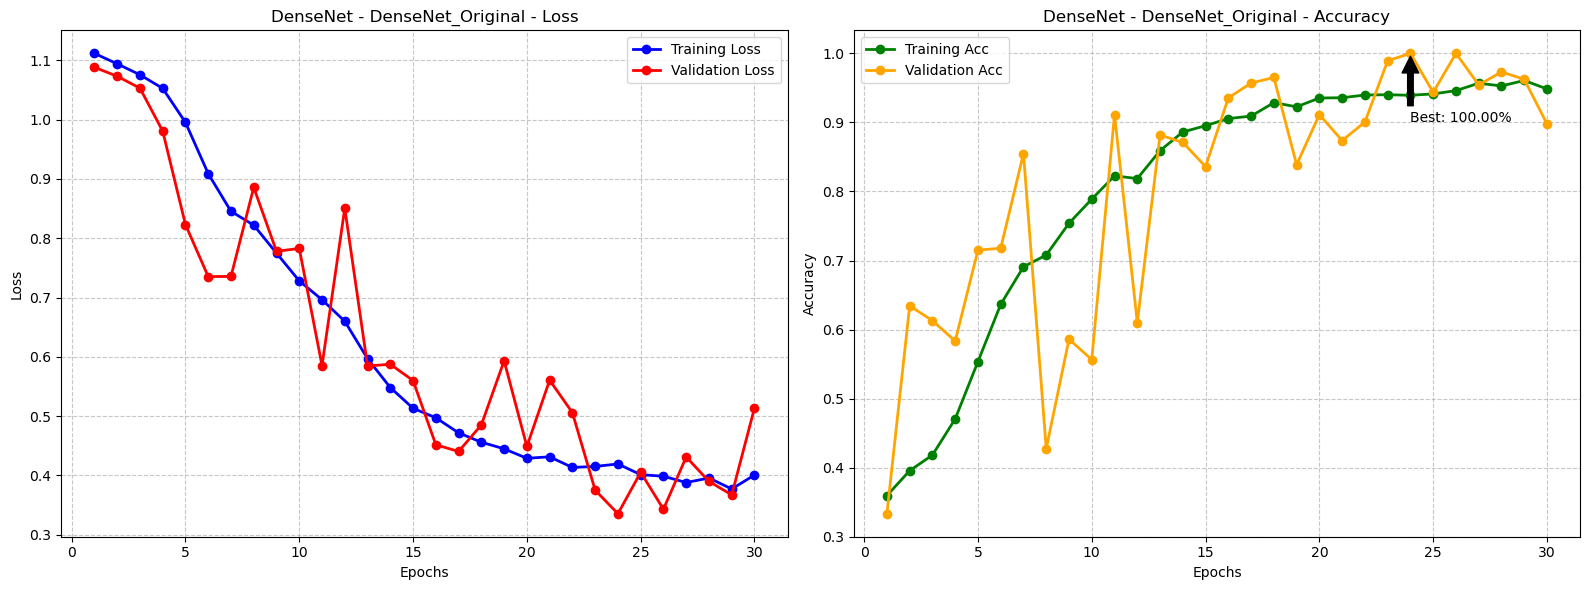

💾 ¡Récord DenseNet! Guardado en checkpoints/5_DenseNet_best.pt (Acc: 1.0000)
📝 Registrando resultados para: 5_DenseNet


,accuracy,precision,recall,f1_macro,inference_time_ms,predictions,targets,training_time_s,config,best_val_acc
1_ANN_Custom,0.555556,0.594949,0.563203,0.542213,180.173189,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",279.685601,"{'bs': 128, 'dr': 0.2, 'lr': 0.001}",0.865591
2_CNN_Custom,0.539683,0.779221,0.534848,0.488977,187.209493,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1121.483709,"{'bs': 32, 'filters': 32, 'dr': 0.2, 'lr': 0.001}",0.943548
3_Transfer_ResNet,0.84127,0.856662,0.837879,0.834447,8.918751,"[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",176.021904,"{'name': 'ResNet_DeepTune_Orig', 'mode': 'fine...",NaN
4_SqueezeNet,0.793651,0.802994,0.788745,0.785799,7.372542,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",399.557929,"{'name': 'SQ_Original', 'bs': 32, 'lr': 0.0001...",NaN
5_DenseNet,0.698413,0.702222,0.696392,0.697639,10.046077,"[0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",856.494145,"{'name': 'DenseNet_Original', 'bs': 128, 'lr':...",NaN


 Memoria liberada. Uso actual: 1.74 GB

--- [DenseNet] Run 2: DenseNet_HighReg (Higher Dropout (0.5) & Lower Batch) ---
Iniciando entrenamiento: DenseNet_HighReg | Epochs: 30 | Patience: 8


/opt/homebrew/Caskroom/miniforge/base/envs/dl_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/30] T.Loss: 1.1309 T.Acc: 0.3524 | V.Loss: 1.0664 V.Acc: 0.3333
Epoch [2/30] T.Loss: 1.0783 T.Acc: 0.4083 | V.Loss: 1.0009 V.Acc: 0.5000
Epoch [3/30] T.Loss: 1.0090 T.Acc: 0.5179 | V.Loss: 0.8465 V.Acc: 0.8306
Epoch [4/30] T.Loss: 0.9232 T.Acc: 0.5865 | V.Loss: 0.9376 V.Acc: 0.5027
Epoch [5/30] T.Loss: 0.8799 T.Acc: 0.6282 | V.Loss: 0.9030 V.Acc: 0.5215
Epoch [6/30] T.Loss: 0.8032 T.Acc: 0.7313 | V.Loss: 1.1222 V.Acc: 0.3333
Epoch [7/30] T.Loss: 0.7661 T.Acc: 0.7429 | V.Loss: 0.7329 V.Acc: 0.7339
Epoch [8/30] T.Loss: 0.7000 T.Acc: 0.7940 | V.Loss: 0.8315 V.Acc: 0.6452
Epoch [9/30] T.Loss: 0.6262 T.Acc: 0.8413 | V.Loss: 0.6088 V.Acc: 0.8011
Epoch [10/30] T.Loss: 0.5572 T.Acc: 0.8885 | V.Loss: 0.5796 V.Acc: 0.8844
Epoch [11/30] T.Loss: 0.5121 T.Acc: 0.9048 | V.Loss: 0.4163 V.Acc: 0.9462
Epoch [12/30] T.Loss: 0.4861 T.Acc: 0.9139 | V.Loss: 0.4423 V.Acc: 0.9677
Epoch [13/30] T.Loss: 0.4666 T.Acc: 0.9246 | V.Loss: 0.5168 V.Acc: 0.8871
Epoch [14/30] T.Loss: 0.4447 T.Acc: 0.9357 | V.

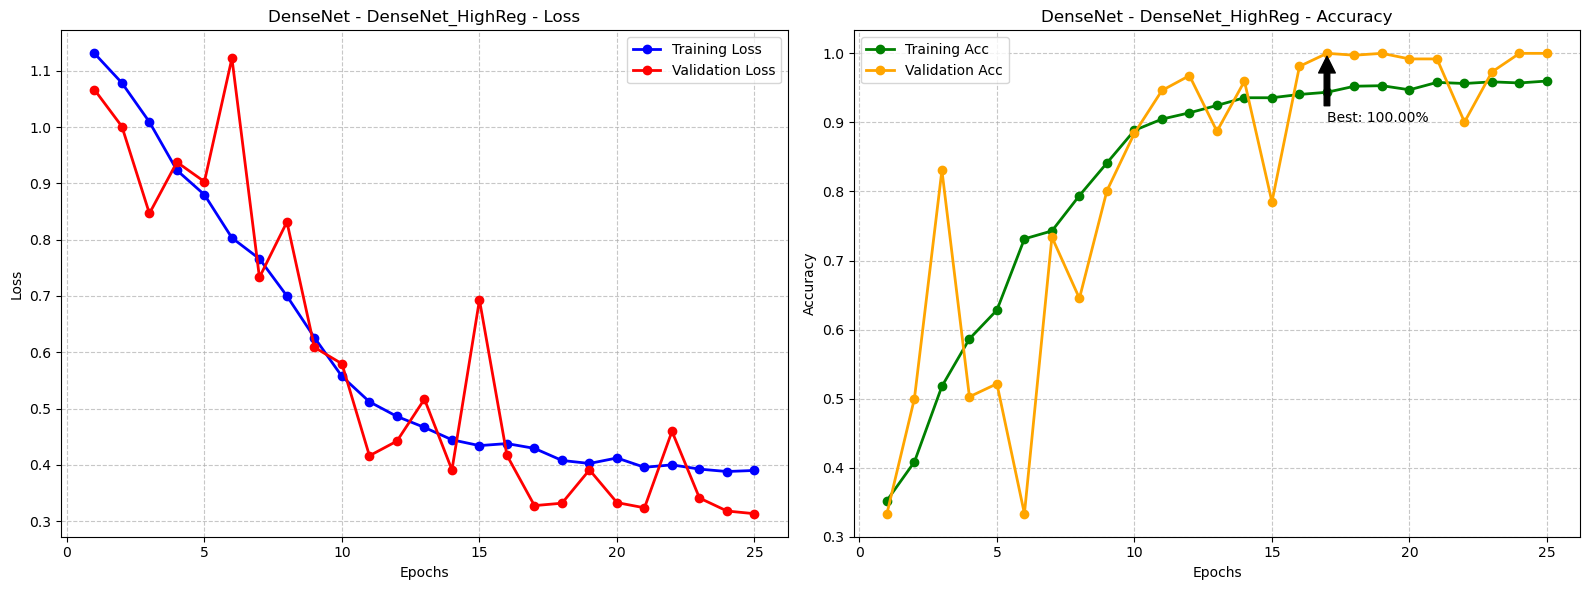

 Memoria liberada. Uso actual: 2.32 GB

--- [DenseNet] Run 3: DenseNet_Slow (Lower LR (1e-4)) ---
Iniciando entrenamiento: DenseNet_Slow | Epochs: 30 | Patience: 8
Epoch [1/30] T.Loss: 1.1105 T.Acc: 0.3254 | V.Loss: 1.0836 V.Acc: 0.3333
Epoch [2/30] T.Loss: 1.0953 T.Acc: 0.3722 | V.Loss: 1.0811 V.Acc: 0.3333
Epoch [3/30] T.Loss: 1.0886 T.Acc: 0.3869 | V.Loss: 1.0757 V.Acc: 0.4113
Epoch [4/30] T.Loss: 1.0793 T.Acc: 0.4095 | V.Loss: 1.0357 V.Acc: 0.5914
Epoch [5/30] T.Loss: 1.0501 T.Acc: 0.4528 | V.Loss: 1.0150 V.Acc: 0.6102
Epoch [6/30] T.Loss: 1.0187 T.Acc: 0.5163 | V.Loss: 0.9530 V.Acc: 0.5430
Epoch [7/30] T.Loss: 0.9719 T.Acc: 0.5738 | V.Loss: 0.8956 V.Acc: 0.7634
Epoch [8/30] T.Loss: 0.9265 T.Acc: 0.6060 | V.Loss: 0.8233 V.Acc: 0.7097
Epoch [9/30] T.Loss: 0.8973 T.Acc: 0.6512 | V.Loss: 0.7954 V.Acc: 0.8656
Epoch [10/30] T.Loss: 0.8721 T.Acc: 0.6536 | V.Loss: 0.7477 V.Acc: 0.9005
Epoch [11/30] T.Loss: 0.8451 T.Acc: 0.6778 | V.Loss: 0.7324 V.Acc: 0.7446
Epoch [12/30] T.Loss: 0.8143 T.

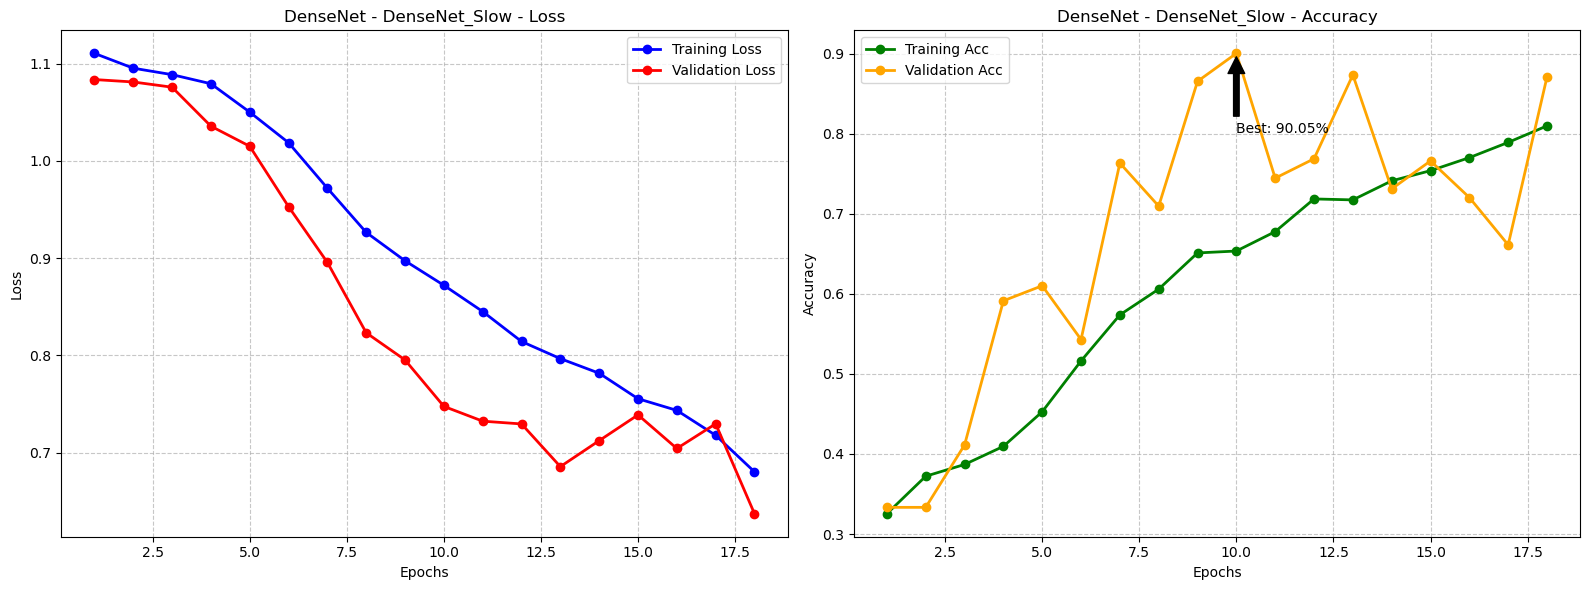

 Memoria liberada. Uso actual: 2.32 GB

🏆 Mejor DenseNet: DenseNet_Original | Val Acc: 1.0000

🏁  RESULTADOS FINALES DEL PROYECTO  🏁

📊 Tabla Comparativa Parcial:


,accuracy,f1_macro,precision,recall,training_time_s,inference_time_ms
3_Transfer_ResNet,0.84127,0.834447,0.856662,0.837879,176.021904,8.918751
4_SqueezeNet,0.793651,0.785799,0.802994,0.788745,399.557929,7.372542
5_DenseNet,0.698413,0.697639,0.702222,0.696392,856.494145,10.046077
1_ANN_Custom,0.555556,0.542213,0.594949,0.563203,279.685601,180.173189
2_CNN_Custom,0.539683,0.488977,0.779221,0.534848,1121.483709,187.209493


In [78]:

def run_densenet_search():
    # Definimos 3 escenarios para asegurar robustez
    experiments = [
        # 1. Baseline Original (Notebook)
        {
            'name': 'DenseNet_Original',
            'bs': 128, 
            'lr': 3e-4, 
            'dr': 0.2,
            'desc': 'Baseline Config (High BS)'
        },
        # 2. Mayor Regularización (Para evitar overfitting si ocurre)
        {
            'name': 'DenseNet_HighReg',
            'bs': 64, 
            'lr': 3e-4, 
            'dr': 0.5,
            'desc': 'Higher Dropout (0.5) & Lower Batch'
        },
        # 3. Fine-Grained (LR bajo para estabilidad)
        {
            'name': 'DenseNet_Slow',
            'bs': 64, 
            'lr': 1e-4, 
            'dr': 0.2,
            'desc': 'Lower LR (1e-4)'
        }
    ]
    
    best_val_acc_global = 0.0
    best_model_name = ""
    
    print(f"🚀 Iniciando Búsqueda DenseNet ({len(experiments)} configs)...")

    for i, cfg in enumerate(experiments):
        print(f"\n--- [DenseNet] Run {i+1}: {cfg['name']} ({cfg['desc']}) ---")
        
        # 1. DataLoaders (Manejo seguro de memoria con num_workers=0)
        try:
            train_dl, valid_dl, test_dl, classes = get_dataloaders(
                TRAIN_PATH, VALID_PATH, TEST_PATH, 
                train_transform_imagenet_v2_simplified, valid_transform_imagenet, cfg['bs']
            )
        except RuntimeError:
            print("⚠️ Memoria llena, reduciendo BS a 32...")
            cfg['bs'] = 32
            train_dl, valid_dl, test_dl, classes = get_dataloaders(
                TRAIN_PATH, VALID_PATH, TEST_PATH, 
                train_transform_imagenet_v2_simplified, valid_transform_imagenet, cfg['bs']
            )

        # 2. Modelo
        model = DenseNetScratch(num_classes=3, dropout_rate=cfg['dr']).to(DEVICE)
        
        # 3. Optimizador (AdamW como en el original)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # 4. Entrenar (30 épocas máximo)
        history, state, t_time = train_val_loop(
            model, train_dl, valid_dl, criterion, optimizer, 
            epochs=30, patience=8, name=cfg['name']
        )
        
        # 5. Graficar métricas
        plot_metrics(history, title=f"DenseNet - {cfg['name']}")
        
        # 6. Comparar y Guardar
        current_acc = max(history['val_acc'])
        if current_acc > best_val_acc_global:
            best_val_acc_global = current_acc
            best_model_name = cfg['name']
            
            save_path = CHECKPOINT_PATH / "5_DenseNet_best.pt"
            torch.save(state, save_path)
            print(f"💾 ¡Récord DenseNet! Guardado en {save_path} (Acc: {current_acc:.4f})")
            
            # Evaluación Final (Carga + TTA)
            model.load_state_dict(state)
            res = evaluate_with_tta(model, test_dl, use_tta=True)
            res['config'] = cfg
            res['training_time_s'] = t_time
            register_result("5_DenseNet", res)
            
        del model, optimizer, criterion, train_dl, valid_dl
        clear_memory()

    print(f"\n🏆 Mejor DenseNet: {best_model_name} | Val Acc: {best_val_acc_global:.4f}")
    
    # --- MOSTRAR TABLA FINAL DE TODOS LOS MODELOS ---
    print("\n" + "="*50)
    print("🏁  RESULTADOS FINALES DEL PROYECTO  🏁")
    print("="*50)
    show_final_table()

# Ejecutar Búsqueda Final
run_densenet_search()